# **MODELOS DE SÉRIES TEMPORAIS PARA PREDIÇÃO PLUVIOMÉTRICA**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 10, 4

## **Tratamento da base de dados**

Importando a base de dados relativa a quantidade de chuva mensal na cidade de São Paulo

In [2]:
chuva = pd.read_csv('Chuva_Mensal.csv',sep=';')

Boas Práticas para análise de dados:

*  Analisar as variaveis do dataframe importado;
*  Verificar o tamanho dataframe;
*  Verificar como o python reconhece as variáveis;
*  Verificar a existência de valores faltantes.

In [3]:
chuva.head()

,Ano,Janeiro,Fevereiro,Março,Abril,Maio,Junho,Julho,Agosto,Setembro,Outubro,Novembro,Dezembro
0,1985,"184,9","242,9",230,59,"126,2","14,6",4,"21,8","126,1","71,1","111,3","155,2"
1,1986,"199,6",221,"218,7","106,5","113,1","3,9","30,3",---,"34,5","60,7","242,5","389,9"
2,1987,"525,8",---,"161,3","98,1","293,8","183,9","11,8","30,9","80,2","84,8","72,7","152,1"
3,1988,"268,7","224,4","189,2","175,1","224,9","58,6","1,3","0,2","28,4","173,9","100,2","289,8"
4,1989,"312,9","344,3","288,2","66,3","21,7","52,5","150,1","32,9","52,1","80,1",88,"236,7"


Possiveis problemas : virgulas e traços (valores nao preenchidos)

Verificando o tamanho da nossa base de dados

In [4]:
chuva.shape

(38, 13)

Análise dos tipos de atributos.
*   object: strings
*   int64: inteiros
*   float64: reais
*   complex: complexos

In [5]:
chuva.dtypes

Ano          object
Janeiro      object
Fevereiro    object
Março        object
Abril        object
Maio         object
Junho        object
Julho        object
Agosto       object
Setembro     object
Outubro      object
Novembro     object
Dezembro     object
dtype: object

Temos todas as variáveis como strings ou objetos

Inicialmente vamos Substituir as vírgulas por pontos

Função lambda -> função anônima (simplifica a escrita da função) - criação direta de função.

Com o .apply a função criada irá percorrer todos valores e subtituir , por .

In [6]:
chuva = chuva.apply(lambda x: x.str.replace(',','.'))
chuva.head()

,Ano,Janeiro,Fevereiro,Março,Abril,Maio,Junho,Julho,Agosto,Setembro,Outubro,Novembro,Dezembro
0,1985,184.9,242.9,230,59,126.2,14.6,4,21.8,126.1,71.1,111.3,155.2
1,1986,199.6,221,218.7,106.5,113.1,3.9,30.3,---,34.5,60.7,242.5,389.9
2,1987,525.8,---,161.3,98.1,293.8,183.9,11.8,30.9,80.2,84.8,72.7,152.1
3,1988,268.7,224.4,189.2,175.1,224.9,58.6,1.3,0.2,28.4,173.9,100.2,289.8
4,1989,312.9,344.3,288.2,66.3,21.7,52.5,150.1,32.9,52.1,80.1,88,236.7


In [7]:
chuva.dtypes

Ano          object
Janeiro      object
Fevereiro    object
Março        object
Abril        object
Maio         object
Junho        object
Julho        object
Agosto       object
Setembro     object
Outubro      object
Novembro     object
Dezembro     object
dtype: object

As variáveis ainda não são do tipo float.

Por isso iremos transformar variáveis categóricas em numéricas e substituir os traços pela média

In [8]:
print(chuva)

         Ano Janeiro Fevereiro   Março  Abril   Maio  Junho  Julho Agosto  \
0       1985   184.9     242.9     230     59  126.2   14.6      4   21.8   
1       1986   199.6       221   218.7  106.5  113.1    3.9   30.3    ---   
2       1987   525.8       ---   161.3   98.1  293.8  183.9   11.8   30.9   
3       1988   268.7     224.4   189.2  175.1  224.9   58.6    1.3    0.2   
4       1989   312.9     344.3   288.2   66.3   21.7   52.5  150.1   32.9   
5       1990   284.1     196.9   310.1   85.8   77.9   50.6  121.2   76.3   
6       1991   330.7     340.3   522.4  200.3   43.3   96.8   28.2   37.3   
7       1992   129.2     258.5     ---   87.2   93.5   11.6   40.9   24.7   
8       1993   221.5     225.7     110   84.6  133.9   74.7   11.2   40.8   
9       1994   196.9     184.4   231.6  111.4   54.9   30.5   39.2    2.4   
10      1995   373.8     383.1   267.7   73.9   79.7   31.2   46.8    1.5   
11      1996   334.3     376.5   284.5   42.3   21.7   45.1   12.2   41.2   

In [9]:
chuva['Janeiro'] =  pd.to_numeric(chuva['Janeiro'].str.replace('---', '305.79'))
chuva['Fevereiro'] =  pd.to_numeric(chuva['Fevereiro'].str.replace('---', '249.3'))
chuva['Março'] =  pd.to_numeric(chuva['Março'].str.replace('---', '227.97'))
chuva['Abril'] =  pd.to_numeric(chuva['Abril'].str.replace('---', '93.64'))
chuva['Maio'] =  pd.to_numeric(chuva['Maio'].str.replace('---', '86.67'))
chuva['Junho'] =  pd.to_numeric(chuva['Junho'].str.replace('---', '59.66'))
chuva['Julho'] =  pd.to_numeric(chuva['Julho'].str.replace('---', '54.6'))
chuva['Agosto'] =  pd.to_numeric(chuva['Agosto'].str.replace('---', '27.85'))
chuva['Setembro'] =  pd.to_numeric(chuva['Setembro'].str.replace('---', '83.8'))
chuva['Outubro'] =  pd.to_numeric(chuva['Outubro'].str.replace('---', '139.89'))
chuva['Novembro'] =  pd.to_numeric(chuva['Novembro'].str.replace('---', '145.04'))
chuva['Dezembro'] =  pd.to_numeric(chuva['Dezembro'].str.replace('---', '236.04'))
print(chuva)

         Ano  Janeiro  Fevereiro   Março   Abril    Maio   Junho  Julho  \
0       1985   184.90      242.9  230.00   59.00  126.20   14.60    4.0   
1       1986   199.60      221.0  218.70  106.50  113.10    3.90   30.3   
2       1987   525.80      249.3  161.30   98.10  293.80  183.90   11.8   
3       1988   268.70      224.4  189.20  175.10  224.90   58.60    1.3   
4       1989   312.90      344.3  288.20   66.30   21.70   52.50  150.1   
5       1990   284.10      196.9  310.10   85.80   77.90   50.60  121.2   
6       1991   330.70      340.3  522.40  200.30   43.30   96.80   28.2   
7       1992   129.20      258.5  227.97   87.20   93.50   11.60   40.9   
8       1993   221.50      225.7  110.00   84.60  133.90   74.70   11.2   
9       1994   196.90      184.4  231.60  111.40   54.90   30.50   39.2   
10      1995   373.80      383.1  267.70   73.90   79.70   31.20   46.8   
11      1996   334.30      376.5  284.50   42.30   21.70   45.10   12.2   
12      1997   235.00    

In [10]:
chuva.dtypes

Ano           object
Janeiro      float64
Fevereiro    float64
Março        float64
Abril        float64
Maio         float64
Junho        float64
Julho        float64
Agosto       float64
Setembro     float64
Outubro      float64
Novembro     float64
Dezembro     float64
dtype: object

Excluir as duas últimas linhas - a média e o ultimo valor para realizarmos a previsão e comparar depois


In [11]:
chuva2 = chuva.drop([36,37])
print(chuva2)

     Ano  Janeiro  Fevereiro   Março  Abril   Maio   Junho  Julho  Agosto  \
0   1985   184.90      242.9  230.00   59.0  126.2   14.60    4.0   21.80   
1   1986   199.60      221.0  218.70  106.5  113.1    3.90   30.3   27.85   
2   1987   525.80      249.3  161.30   98.1  293.8  183.90   11.8   30.90   
3   1988   268.70      224.4  189.20  175.1  224.9   58.60    1.3    0.20   
4   1989   312.90      344.3  288.20   66.3   21.7   52.50  150.1   32.90   
5   1990   284.10      196.9  310.10   85.8   77.9   50.60  121.2   76.30   
6   1991   330.70      340.3  522.40  200.3   43.3   96.80   28.2   37.30   
7   1992   129.20      258.5  227.97   87.2   93.5   11.60   40.9   24.70   
8   1993   221.50      225.7  110.00   84.6  133.9   74.70   11.2   40.80   
9   1994   196.90      184.4  231.60  111.4   54.9   30.50   39.2    2.40   
10  1995   373.80      383.1  267.70   73.9   79.7   31.20   46.8    1.50   
11  1996   334.30      376.5  284.50   42.3   21.7   45.10   12.2   41.20   

Estrutura da base de dados está ideal?

Teremos que formatar a tabela para criar nossa série temporal

In [12]:
chuva2 = chuva2.drop(columns='Ano')
chuva2.head()

,Janeiro,Fevereiro,Março,Abril,Maio,Junho,Julho,Agosto,Setembro,Outubro,Novembro,Dezembro
0,184.9,242.9,230.0,59.0,126.2,14.6,4.0,21.80,126.1,71.1,111.3,155.2
1,199.6,221.0,218.7,106.5,113.1,3.9,30.3,27.85,34.5,60.7,242.5,389.9
2,525.8,249.3,161.3,98.1,293.8,183.9,11.8,30.90,80.2,84.8,72.7,152.1
3,268.7,224.4,189.2,175.1,224.9,58.6,1.3,0.20,28.4,173.9,100.2,289.8
4,312.9,344.3,288.2,66.3,21.7,52.5,150.1,32.90,52.1,80.1,88.0,236.7


Temos que configurar a tabela de maneira a ordenar os registros por linha

Transformar em Array resolveria o problema?

In [13]:
chuva3 = chuva2.values
chuva3

array([[1.8490e+02, 2.4290e+02, 2.3000e+02, 5.9000e+01, 1.2620e+02,
        1.4600e+01, 4.0000e+00, 2.1800e+01, 1.2610e+02, 7.1100e+01,
        1.1130e+02, 1.5520e+02],
       [1.9960e+02, 2.2100e+02, 2.1870e+02, 1.0650e+02, 1.1310e+02,
        3.9000e+00, 3.0300e+01, 2.7850e+01, 3.4500e+01, 6.0700e+01,
        2.4250e+02, 3.8990e+02],
       [5.2580e+02, 2.4930e+02, 1.6130e+02, 9.8100e+01, 2.9380e+02,
        1.8390e+02, 1.1800e+01, 3.0900e+01, 8.0200e+01, 8.4800e+01,
        7.2700e+01, 1.5210e+02],
       [2.6870e+02, 2.2440e+02, 1.8920e+02, 1.7510e+02, 2.2490e+02,
        5.8600e+01, 1.3000e+00, 2.0000e-01, 2.8400e+01, 1.7390e+02,
        1.0020e+02, 2.8980e+02],
       [3.1290e+02, 3.4430e+02, 2.8820e+02, 6.6300e+01, 2.1700e+01,
        5.2500e+01, 1.5010e+02, 3.2900e+01, 5.2100e+01, 8.0100e+01,
        8.8000e+01, 2.3670e+02],
       [2.8410e+02, 1.9690e+02, 3.1010e+02, 8.5800e+01, 7.7900e+01,
        5.0600e+01, 1.2120e+02, 7.6300e+01, 9.7200e+01, 2.0680e+02,
        1.1630e+02,

Teriamos vários vetores por conta da quebra de linhas

Transformando em uam lista sem quebras


In [14]:
chuva4 = list(chuva3.flatten())
print(chuva4)

[184.9, 242.9, 230.0, 59.0, 126.2, 14.6, 4.0, 21.8, 126.1, 71.1, 111.3, 155.2, 199.6, 221.0, 218.7, 106.5, 113.1, 3.9, 30.3, 27.85, 34.5, 60.7, 242.5, 389.9, 525.8, 249.3, 161.3, 98.1, 293.8, 183.9, 11.8, 30.9, 80.2, 84.8, 72.7, 152.1, 268.7, 224.4, 189.2, 175.1, 224.9, 58.6, 1.3, 0.2, 28.4, 173.9, 100.2, 289.8, 312.9, 344.3, 288.2, 66.3, 21.7, 52.5, 150.1, 32.9, 52.1, 80.1, 88.0, 236.7, 284.1, 196.9, 310.1, 85.8, 77.9, 50.6, 121.2, 76.3, 97.2, 206.8, 116.3, 149.8, 330.7, 340.3, 522.4, 200.3, 43.3, 96.8, 28.2, 37.3, 101.4, 168.0, 67.3, 237.9, 129.2, 258.5, 227.97, 87.2, 93.5, 11.6, 40.9, 24.7, 150.6, 219.6, 145.04, 211.7, 221.5, 225.7, 110.0, 84.6, 133.9, 74.7, 11.2, 40.8, 210.1, 134.1, 125.5, 170.5, 196.9, 184.4, 231.6, 111.4, 54.9, 30.5, 39.2, 2.4, 1.8, 147.6, 86.6, 276.3, 373.8, 383.1, 267.7, 73.9, 79.7, 31.2, 46.8, 1.5, 44.2, 202.6, 115.1, 236.04, 334.3, 376.5, 284.5, 42.3, 21.7, 45.1, 12.2, 41.2, 179.4, 179.8, 87.4, 243.9, 235.0, 187.6, 57.1, 63.2, 88.2, 124.7, 12.5, 28.8, 118.0, 

Transformar em lista sem quebra, por isso utilizamos o comando .flatten()

Criando um range de datas, mensalmente a partir de 1985, e a partir da quantidade de registros na lista chuva4

In [15]:
indice = pd.date_range('1985', periods = len(chuva4), freq = 'M')
indice

DatetimeIndex(['1985-01-31', '1985-02-28', '1985-03-31', '1985-04-30',
               '1985-05-31', '1985-06-30', '1985-07-31', '1985-08-31',
               '1985-09-30', '1985-10-31',
               ...
               '2020-03-31', '2020-04-30', '2020-05-31', '2020-06-30',
               '2020-07-31', '2020-08-31', '2020-09-30', '2020-10-31',
               '2020-11-30', '2020-12-31'],
              dtype='datetime64[ns]', length=432, freq='M')

Criando a série temporal

In [16]:
serie = pd.Series(chuva4, index = indice)
serie

1985-01-31    184.90
1985-02-28    242.90
1985-03-31    230.00
1985-04-30     59.00
1985-05-31    126.20
               ...  
2020-08-31     62.10
2020-09-30     22.90
2020-10-31    213.90
2020-11-30    162.10
2020-12-31    236.04
Freq: M, Length: 432, dtype: float64

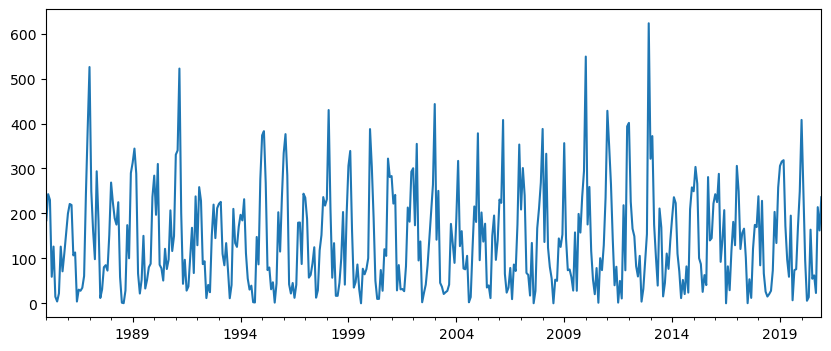

In [17]:
serie.plot()
plt.show()

Análise e preparação da Série Temporal

Analisando a tendência

Calculando a média móvel para suavização da série.

*   Utilizando janela de 6 meses
*   Retiramos a média dessa janela


In [21]:
media_movel = serie.rolling(window=12)
media_movel = media_movel.mean()

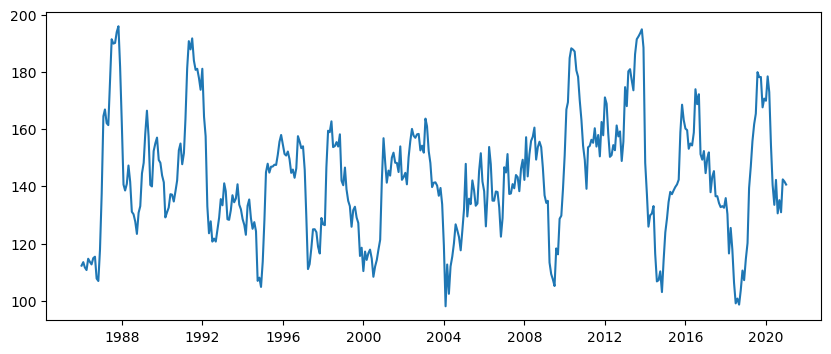

In [22]:
plt.plot(media_movel);

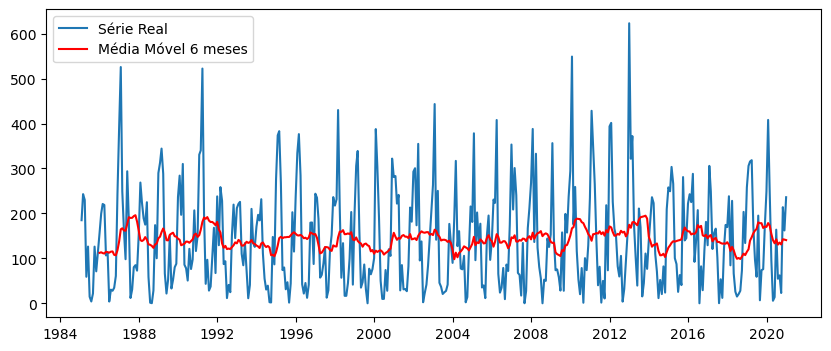

In [23]:
plt.plot(serie, label='Série Real')
plt.plot(media_movel,color='red', label='Média Móvel 6 meses')
plt.legend(loc='best')
plt.show()

Existe oscilação na média móvel, porém bem mais suave do que da série real.  (redução de amplitude)

A média movel facilita na verificação da existencia de tendência de crescimento ou decrescimento da série.

Podemos aumentar a janela da média móvel para verificar mais claramente a ausência do fator de tendência

**Decomposição**

Iremos realizar a decomposição da série para analisarmos a tendencia, sazonalidade e resíduos

In [24]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [25]:
decomposicao = seasonal_decompose(serie)

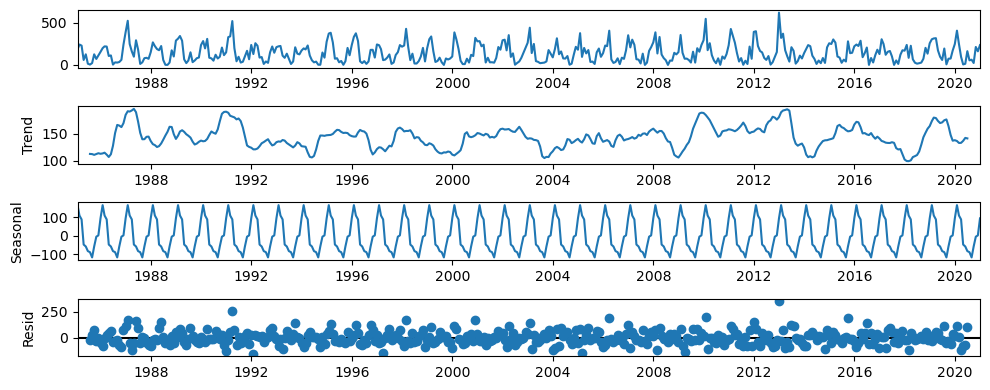

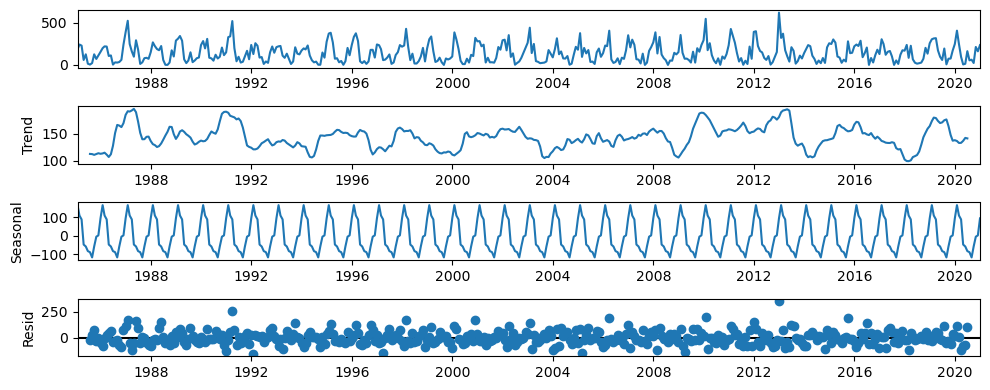

In [26]:
decomposicao.plot()

No primeiro gráfico temos a série temporal real.

No segundo a tendencia, que evidencia há ausência de tendencia crescente ou decrescente. Existe uma oscilação porém não é possível identificar um ciclo bem definido.

No terceiro a sazonalidade forte e constante , os picos não aumentam nem dinuem, eles se matem constantes ao longo da série, e com intervalos bem definidos

E no quarto gráfico podemos observar os resíduos que estão aparentemente aleatorios em torno de zero.

Análise de resíduos é muito importante pois ela que nos mostram a qualidade do nosso modelo, como verememos mais a frente.

### **Normalidade e Transformação**

In [27]:
import scipy.stats as stats

Verificando a normalidade dos dados da série

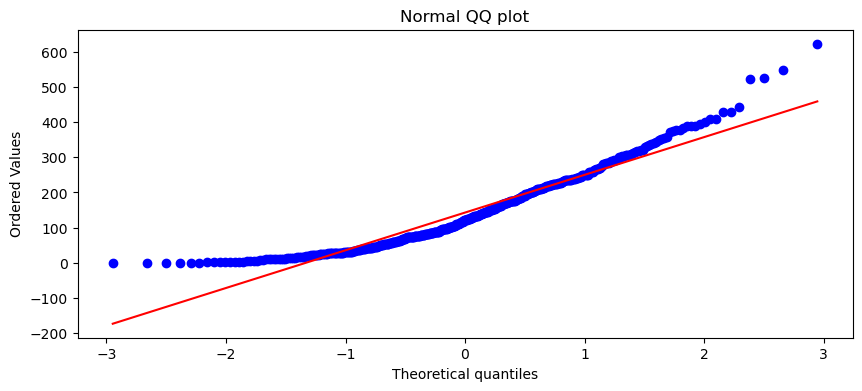

In [28]:
stats.probplot(serie, dist="norm", plot=plt)
plt.title("Normal QQ plot")
plt.show()

Podemos verificar que os dados não se aproximam de uma distribuição normal, apenas alguns pontos estão proximos da linha de referencia.
E alguns pontos principalmente no início e fim da série estão bem distantes da linha de referência.

Fazendo o teste de Sahpiro-Wilk para confirmar a ausência de normalidade

**Teste Shapiro-Wilk**

CRITÉRIOS:

NÍVEL DE SIGNIFICÂNCIA DE 0,05 ou 5% (MAIS UTILIZADO)

Ho = distribuição normal p > 0,05

Ha = distribuição não normal p <= 0,05

In [29]:
e, p = stats.shapiro(serie)
print('Estatística de teste: {}'.format(e))
print('p-valor: {}'.format(p))

Estatística de teste: 0.9260316491127014
p-valor: 9.107363301008586e-14


Vamos tentar aproximar de uma distribuição normal

Inicialmente iremos realizar uma tranformação Transformação por log, buscando diminuir variância e melhorar normalidade.

In [30]:
serie2 = np.log(serie)
serie2

C:\Users\anail\anaconda3\Lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


1985-01-31    5.219815
1985-02-28    5.492650
1985-03-31    5.438079
1985-04-30    4.077537
1985-05-31    4.837868
                ...   
2020-08-31    4.128746
2020-09-30    3.131137
2020-10-31    5.365509
2020-11-30    5.088213
2020-12-31    5.464001
Freq: M, Length: 432, dtype: float64

In [31]:
e, p = stats.shapiro(serie2)
print('Estatística de teste: {}'.format(e))
print('p-valor: {}'.format(p))

Estatística de teste: nan
p-valor: 1.0


Como na função logarítimica não podemos ter zero ou valores negativos por isso a função apresenta erro.

Então tentaremos outro tipo de transformação.

Transformação por raiz cúbica é muito utilizada quando na série temos dados com valor zero ou negativos.

In [32]:
serie3 = np.sign(serie)*abs(serie)**(1/3)
serie3

1985-01-31    5.696992
1985-02-28    6.239395
1985-03-31    6.126926
1985-04-30    3.892996
1985-05-31    5.015949
                ...   
2020-08-31    3.960018
2020-09-30    2.839739
2020-10-31    5.980492
2020-11-30    5.452483
2020-12-31    6.180096
Freq: M, Length: 432, dtype: float64

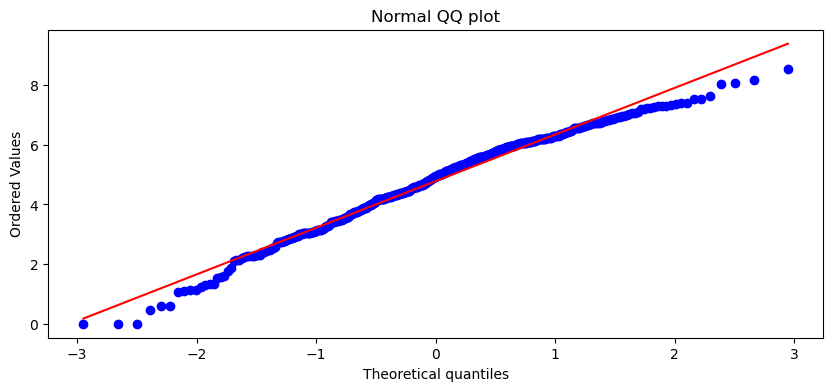

In [33]:
stats.probplot(serie3, dist="norm", plot=plt)
plt.title("Normal QQ plot")
plt.show()

Observamos uma melhora significativa, em relação ao ajuste dos dados, porém ainda temos muitos pontos distantes da linha de referencia, o que possivelmente resultará em uma série que ainda não é aproximadamente normal.

Fazendo o teste de hipótese para verificar se os dados seguem uma distribuição normal.

**Teste Shapiro-Wilk**

CRITÉRIOS:

NÍVEL DE SIGNIFICÂNCIA DE 0,05 ou 5% (MAIS UTILIZADO)

Ho = distribuição normal p > 0,05

Ha = distribuição não normal p <= 0,05

In [34]:
e, p =stats.shapiro(serie3)
print('Estatística de teste: {}'.format(e))
print('p-valor: {}'.format(p))

Estatística de teste: 0.9826489090919495
p-valor: 4.832631748286076e-05


Ainda não temos uma série normal.

C:\Users\anail\AppData\Local\Temp\ipykernel_13324\3051758847.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(serie);


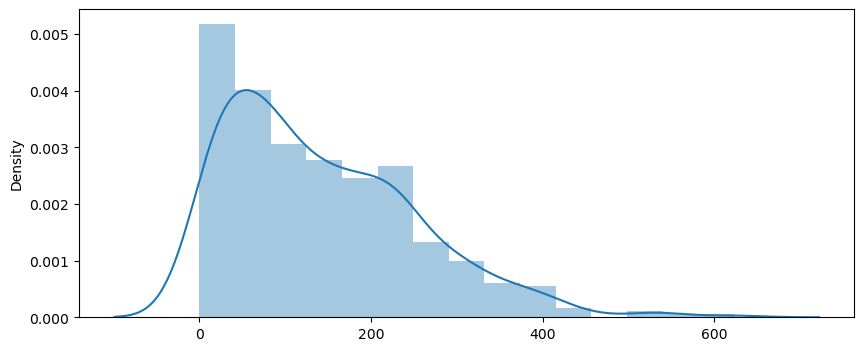

In [35]:
import seaborn as sns
sns.distplot(serie);

C:\Users\anail\AppData\Local\Temp\ipykernel_13324\1562955510.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(serie3);


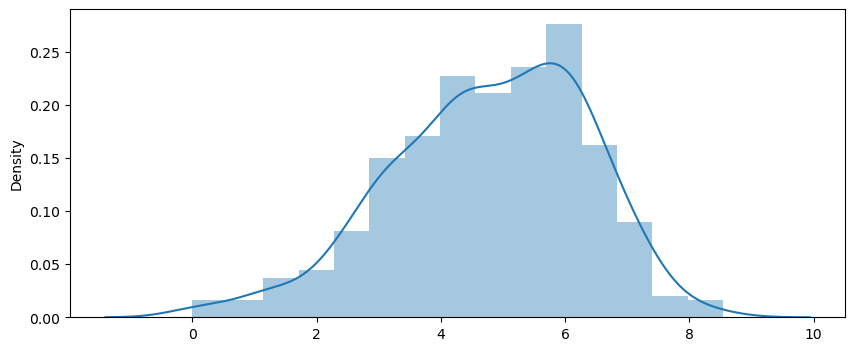

In [36]:
sns.distplot(serie3);

Observamos que a série melhora bastante sua disposição, e se aproxima mais da normalidade.

Sempre temos que buscar uma série que aproxima de uma distribuição normal para termos modelos melhores.

Não é recomendado ficar tentando transformações sobrepostas para obter a normalidade.

### **Estacionaridade**

Média e variância constantes independente do tempo que a série é observada.

In [37]:
import statsmodels.tsa.stattools

Teste KPSS (Kwiatkowski-Phillips-Schmidt-Shin)

Ha = não é estacionário: estatística do teste > valor crítico

Ho = é estacionário:  estatística do teste < valor crítico

In [38]:
kpss = statsmodels.tsa.stattools.kpss(serie3)
print('Estatítica do teste: {:.4f}'.format(kpss[0]))
print('p_valor: {:.4f}'.format(kpss[1]))
print('Valores Críticos:')
for chave, valor in kpss[3].items():
   print('{}: {:.4f}'.format(chave, valor))

Estatítica do teste: 0.0199
p_valor: 0.1000
Valores Críticos:
10%: 0.3470
5%: 0.4630
2.5%: 0.5740
1%: 0.7390


C:\Users\anail\anaconda3\Lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


Caso não fosse estacionária poderia tentar fazer a diferenciação:

serie5 = np.diff(serie3)

### **Autocorrelação**

In [39]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

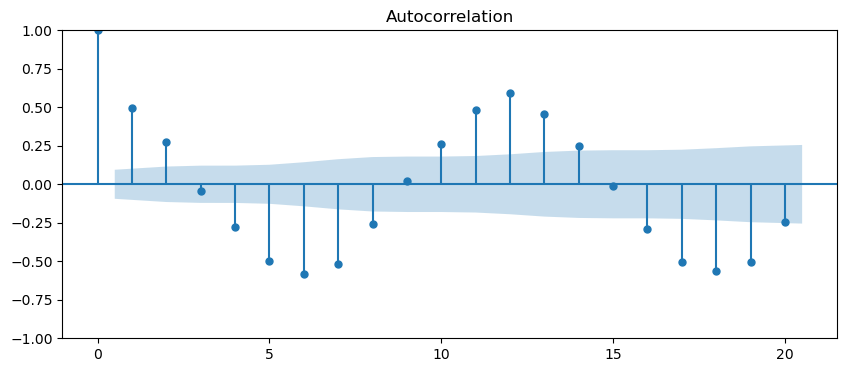

In [40]:
plot_acf(serie3, lags=20)
plt.show()

ACF - Autocorrelação de valores vizinhos

O gráfico indica que temos autocorrelação, entre os valores da própria série, e ainda mostra uma forte sazonalidade.

C:\Users\anail\anaconda3\Lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


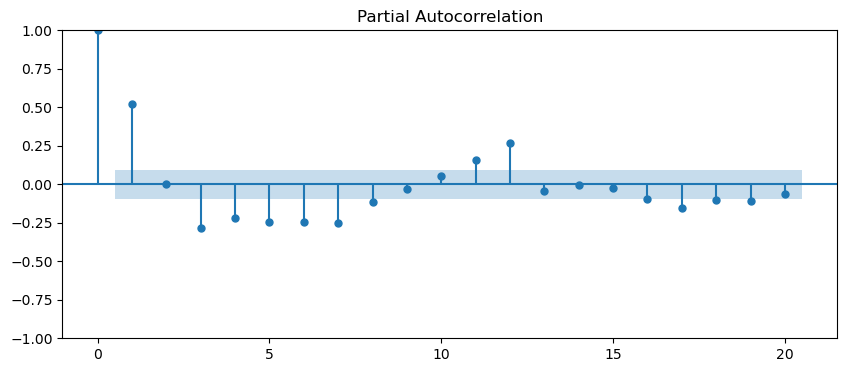

In [41]:
plot_pacf(serie, lags=20)
plt.show()

PACF - correlação entre valores intercalados - autocorrelação Parcial

Temos muitos valores que ultrapassam o intvalo, logo os dados são autocorrelacionados quando analisamos os valores intercalados.


A série é autocorrelacionada, mas não tem problema, pois esse é um pressuposto da análise de modelos de séries temporais.

Logo temos uma série autocorrelacionada, e estacionária, porem seus dados não são normais

## **Modelo AR**

Modelo AR - Modelo Autoregressivo

Modelo ARIMA:(p,d,q)

*   p: ordem da autoregressão
*   d: grau de diferenciação (para transformar em estacionario)
*   q: Ordem de média móvel dos reísduos

Obs: cuidado para nao confundir a Média móvel que iremos analisar não é a média móvel que construímos para suavizar a tendência.
Essa média móvel está relacionada a combinação linear dos erros de valores passados

Modelo ar: (p,0,0)

Só colocamos valores numéricos para a ordem de autoregressão

In [42]:
from statsmodels.tsa.arima.model import ARIMA

Criando o Modelo AR

In [43]:
modelo_ar = ARIMA(serie3, order = (1,0,0))

Temos que analisar o modelo

In [44]:
resultado = modelo_ar.fit()
print(resultado.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  432
Model:                 ARIMA(1, 0, 0)   Log Likelihood                -746.221
Date:                Mon, 27 Nov 2023   AIC                           1498.443
Time:                        21:40:43   BIC                           1510.648
Sample:                    01-31-1985   HQIC                          1503.261
                         - 12-31-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.7871      0.143     33.428      0.000       4.506       5.068
ar.L1          0.4959      0.047     10.622      0.000       0.404       0.587
sigma2         1.8519      0.121     15.268      0.0

O AIC é a métrica mais recomendada para avaliar o modelo uma vez que existem alguns modelos que não retornam o BIC.

Obs.: O recomendado é termos valores de AR até 10, pois depois que incluirmos a sazonalidade o processo pode ficar muito demorado, além do tempo computacional aumentar, o modelo geralmente não melhora significativamente após esse valor.

Para identificar o valor que devemos incluir na métrica AR, devemos analisar o gráfico de acf

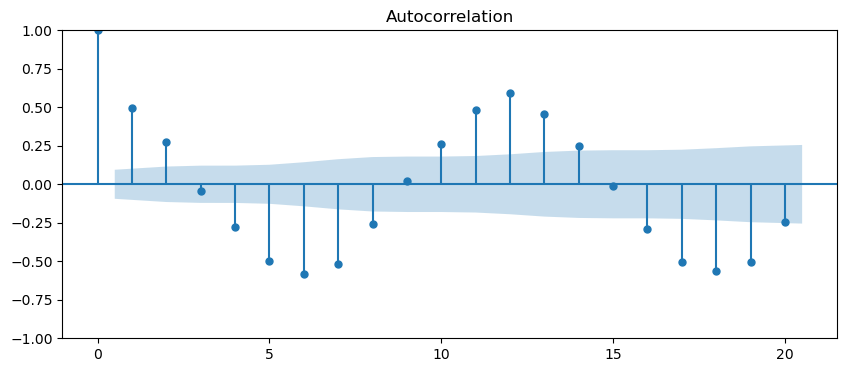

In [45]:
plot_acf(serie3, lags=20)
plt.show()

É interessante analisar os lags que tiveram mudanças bruscas, neste caso o 3 , pois não é correlacionado com o lag 2, o 4 pois "virou" autocorrelacionado, o 9 e 10 pelos mesmo motivos.

In [46]:
modelo_ar3 = ARIMA(serie3, order = (3,0,0))
resultado3 = modelo_ar3.fit()
modelo_ar4 = ARIMA(serie3, order = (4,0,0))
resultado4 = modelo_ar4.fit()
modelo_ar9 = ARIMA(serie3, order = (9,0,0))
resultado9 = modelo_ar9.fit()
modelo_ar10 = ARIMA(serie3, order = (10,0,0))
resultado10 = modelo_ar10.fit()

resultado3.aic

1471.7987585849507

In [47]:
resultado4.aic

1444.6371028044787

In [48]:
resultado9.aic

1337.9223302573837

In [49]:
resultado10.aic

1339.9190524401113

Modelo Final

In [50]:
modelo_ar = ARIMA(serie3, order = (9,0,0))
resultado = modelo_ar.fit()

Melhor AIC: 1337.922 = (9,0,0)

### **Análise dos Resíduos**

In [51]:
residuos = resultado.resid
residuos

1985-01-31    0.915755
1985-02-28    1.009225
1985-03-31    0.621499
1985-04-30   -1.541707
1985-05-31    0.749286
                ...   
2020-08-31   -0.237112
2020-09-30   -2.025517
2020-10-31    0.328097
2020-11-30   -0.775205
2020-12-31    0.173581
Freq: M, Length: 432, dtype: float64

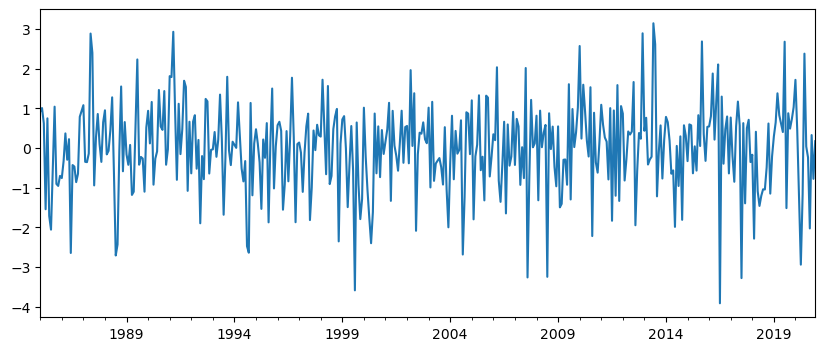

In [52]:
residuos.plot()
plt.show()

Analise no gráfico de resíduos -> média e a variância.

O ideal é que a média seja aproximadamente zero e a variância constante. (ruído branco)

Observa-se que os resíduos tem média zero ao longo da serie.

Já a variância não aparenta ser constante, pois sua amplitude varia.

**Normalidade**

Testando a normalidade dos resíduos

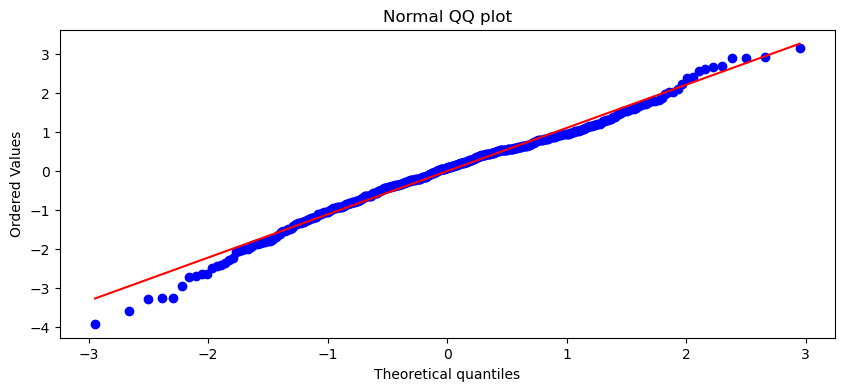

In [53]:
stats.probplot(residuos, dist="norm", plot=plt)
plt.title("Normal QQ plot")
plt.show()

Aparentemente não teremos dados normais, observa-se um distanciamento dos pontos em relação a linha de referência no início e fim do grafico.

**Teste Shapiro-Wilk**

CRITÉRIOS:

NÍVEL DE SIGNIFICÂNCIA DE 0,05 ou 5% (MAIS UTILIZADO)

Ho = distribuição normal p > 0,05

Ha = distribuição não normal p <= 0,05

In [54]:
e, p = stats.shapiro(residuos)
print('Estatística de teste: {}'.format(e))
print('p-valor: {}'.format(p))

Estatística de teste: 0.9866629838943481
p-valor: 0.0005366815021261573


Pelo teste de hipótese os dados não são normais

C:\Users\anail\AppData\Local\Temp\ipykernel_13324\3564404282.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(residuos);


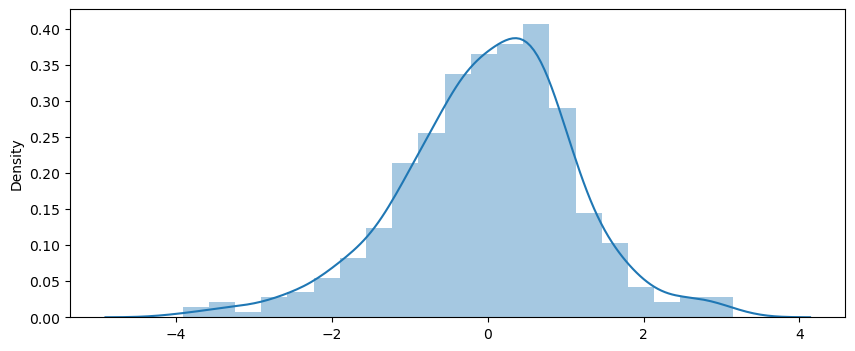

In [55]:
import seaborn as sns
sns.distplot(residuos);

A distribuição se aproxima de uma distribuição normal.

Pela analise de resíduos nosso modelo não ficou "perfeito" e pode apresentar falhas na previsão.

Resultados obtidos até agora em nosso modelo:


*   Distribuição dos resíduos apresenta uma média constante, sem presença de tendencia
*   Dados não normais

Agora vamos analisar a autocorrelação. Neste caso o ideal é que o resíduos NÃO SEJAM autocorrelacionados.



**Autocorrelação**

In [56]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

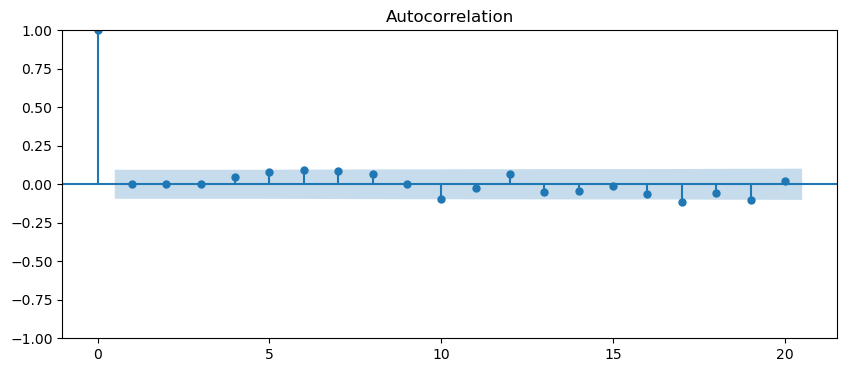

In [57]:
plot_acf(residuos, lags=20)
plt.show()

A grande maioria dos pontos esta dentro do intervalo de confiança, logo os residuos não são autocorrelacionados.

Validando a ausencia da autocorrelação com o pacf

C:\Users\anail\anaconda3\Lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


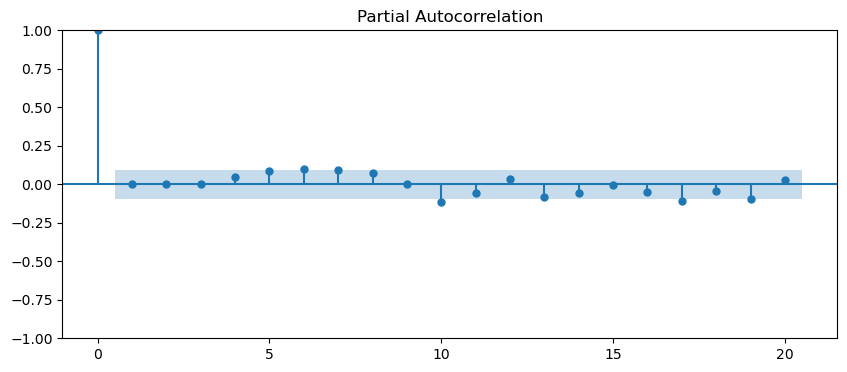

In [58]:
plot_pacf(residuos, lags=20)
plt.show()

A grande maioria dos pontos esta dentro do intervalo de confiança, logo os residuos não são autocorrelacionadas

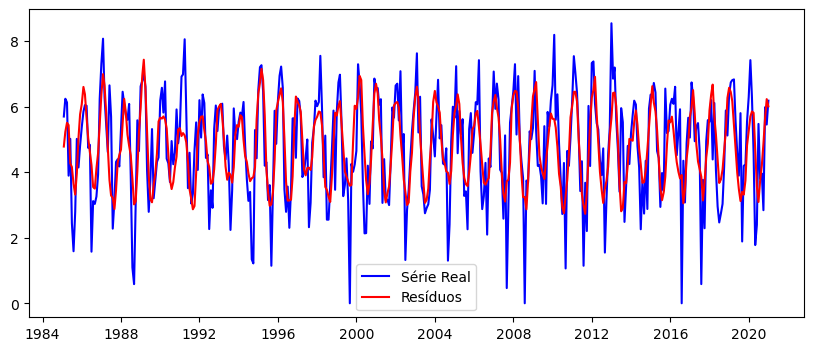

In [59]:
plt.plot(serie3,color='blue', label='Série Real')
plt.plot(serie3-residuos,color='red', label='Resíduos')
plt.legend(loc='best')
plt.show()

Os residuos conseguem seguir bem o padrão de oscilação da serie real

**Previsão**

In [60]:
resultado.fittedvalues

1985-01-31    4.781238
1985-02-28    5.230171
1985-03-31    5.505427
1985-04-30    5.434703
1985-05-31    4.266663
                ...   
2020-08-31    4.197130
2020-09-30    4.865256
2020-10-31    5.652395
2020-11-30    6.227689
2020-12-31    6.006515
Freq: M, Length: 432, dtype: float64

fittedvalues -> mostra os valores que foram ajustados com o modelo

Temos duas formas de fazer previsão: Predict e forecast

O tamanho da nossa série (Length) é 432 , porem o python começa a contabilizar no 0.

In [61]:
previsao = resultado.predict(431, end=443)
previsao

2020-12-31    6.006515
2021-01-31    5.402718
2021-02-28    5.501531
2021-03-31    5.218810
2021-04-30    4.775558
2021-05-31    4.053952
2021-06-30    3.847772
2021-07-31    3.911298
2021-08-31    4.199248
2021-09-30    4.517324
2021-10-31    4.889518
2021-11-30    5.264147
2021-12-31    5.513972
Freq: M, Name: predicted_mean, dtype: float64

In [62]:
previsao2 = resultado.forecast(12)
previsao2

2021-01-31    5.402718
2021-02-28    5.501531
2021-03-31    5.218810
2021-04-30    4.775558
2021-05-31    4.053952
2021-06-30    3.847772
2021-07-31    3.911298
2021-08-31    4.199248
2021-09-30    4.517324
2021-10-31    4.889518
2021-11-30    5.264147
2021-12-31    5.513972
Freq: M, Name: predicted_mean, dtype: float64

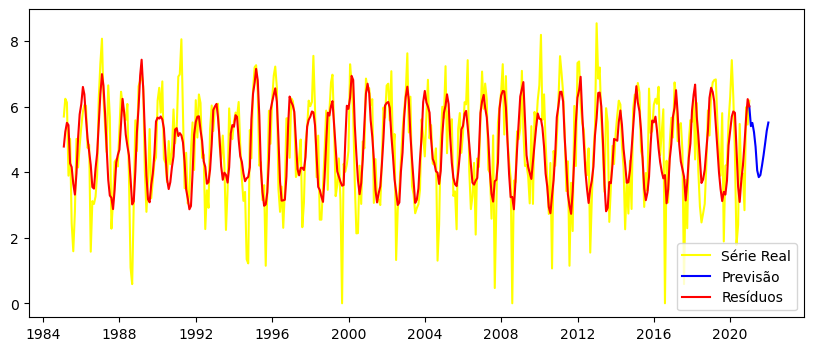

In [67]:
plt.plot(serie3,color='yellow', label='Série Real')
plt.plot(previsao,color='blue', label='Previsão')
plt.plot(serie3-residuos,color='red', label='Resíduos')
plt.legend(loc='best')
plt.show()

Como os dados foram transformados, a escala apresenta no grafico nao é a escala real da série.

Como tinhamos retirado a raiz cúbica, iremos elevar a 3 agora.

In [64]:
prev_escala = pd.DataFrame(previsao ** 3)
prev_escala

,predicted_mean
2020-12-31,216.704344
2021-01-31,157.701867
2021-02-28,166.513965
2021-03-31,142.139391
2021-04-30,108.911170
2021-05-31,66.624801
2021-06-30,56.967627
2021-07-31,59.836001
2021-08-31,74.048218
2021-09-30,92.181479


Plotando os valores reais

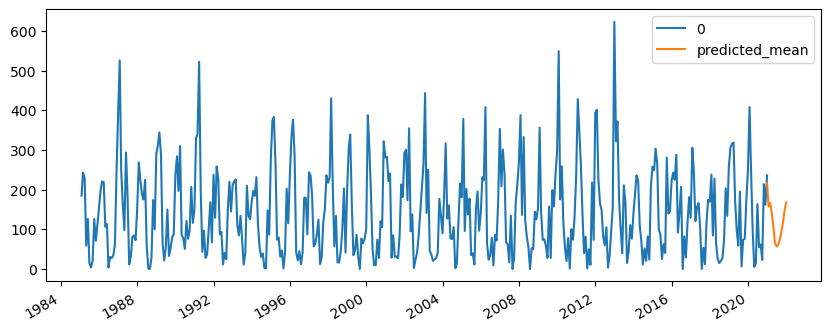

In [65]:
pd.concat([serie,prev_escala]).plot();

## **Modelo MA**

Modelo de Média Móvel - Está relacionado ao erro de regressão. Ele faz uma relação linear dos erros anteriores, erros passados.

Esta média móvel é diferente da realizada anteriormente para analisar as tendencias.

Modelo arima:(p,d,q)



*   p: ordem da autoregressão
*   d: grau de diferenciação (para transformar em estacionario)
*   q: Ordem de média móvel dos resíduos


Modelo MA: (0,0,q)

Existe uma limitação sugerida de chegarmos até aproximadamente 10 na escolha da ordem da média movel

In [68]:
from statsmodels.tsa.arima.model import ARIMA

Criando o modelo MA

In [69]:
modelo_ma1 = ARIMA(serie3, order = (0,0,1))
resultado1 = modelo_ma1.fit()
modelo_ma2 = ARIMA(serie3, order = (0,0,2))
resultado2 = modelo_ma2.fit()
modelo_ma3 = ARIMA(serie3, order = (0,0,3))
resultado3 = modelo_ma3.fit()
modelo_ma4 = ARIMA(serie3, order = (0,0,4))
resultado5 = modelo_ma4.fit()
modelo_ma5 = ARIMA(serie3, order = (0,0,5))
resultado5 = modelo_ma5.fit()
modelo_ma6 = ARIMA(serie3, order = (0,0,6))
resultado6 = modelo_ma6.fit()
modelo_ma7 = ARIMA(serie3, order = (0,0,7))
resultado7 = modelo_ma7.fit()
modelo_ma8 = ARIMA(serie3, order = (0,0,8))
resultado8 = modelo_ma8.fit()
modelo_ma9 = ARIMA(serie3, order = (0,0,9))
resultado9 = modelo_ma9.fit()
modelo_ma10 = ARIMA(serie3, order = (0,0,10))
resultado10 = modelo_ma10.fit()
resultado1.aic

1534.551175332206

In [70]:
resultado2.aic

1490.5965121281877

In [71]:
resultado3.aic

1486.8987972225304

In [72]:
resultado4.aic

1444.6371028044787

In [73]:
resultado5.aic

1473.1575585382527

In [74]:
resultado6.aic

1448.6847018062758

In [75]:
resultado7.aic

1416.1807770350788

In [76]:
resultado8.aic

1411.6962854900355

In [77]:
resultado9.aic

1413.4814835283537

In [78]:
resultado10.aic

1415.1744165311845

Para o modelo de MA, podemos testar os 10 valores para selecionar o modelo que tem o menor AIC.

In [79]:
resultado_ma = modelo_ma8.fit()
print(resultado_ma.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  432
Model:                 ARIMA(0, 0, 8)   Log Likelihood                -695.848
Date:                Mon, 27 Nov 2023   AIC                           1411.696
Time:                        21:56:58   BIC                           1452.381
Sample:                    01-31-1985   HQIC                          1427.758
                         - 12-31-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.7863      0.028    172.577      0.000       4.732       4.841
ma.L1          0.3130      0.051      6.129      0.000       0.213       0.413
ma.L2          0.2280      0.051      4.501      0.0

Modelo AR: AIC = 1337.922 (9,0,0)

Modelo MA: AIC = 1411.696 (0,0,8)

### **Análise dos Resíduos**

Fazendo a analise de resíduos para o modelo que tem o melhor AIC.

Lembrando que o ideal é que os resíduos tenha media zero e variancia contante ao longo da série. (Ruído Branco)

In [80]:
residuos_ma = resultado_ma.resid

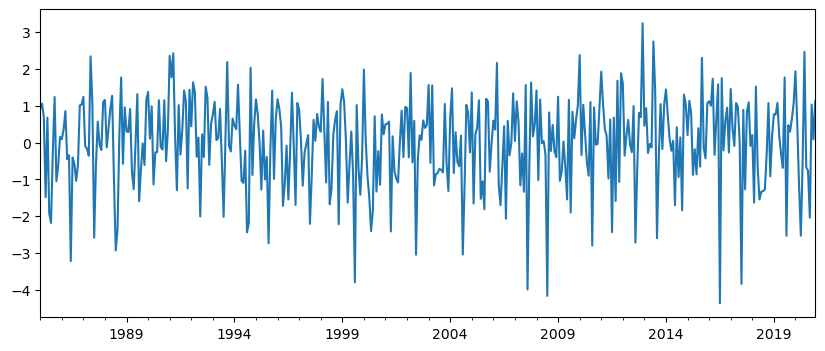

In [81]:
residuos_ma.plot()
plt.show()

Existem muitos picos, principalmente na parte inferiror, mas no geral temos uma média aparentemente constate em torno de zero.

**Normalidade**

Analisando a Normalidade dos resíduos

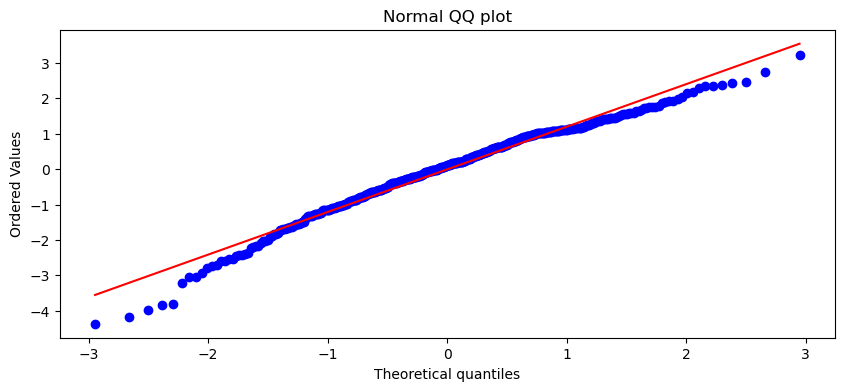

In [82]:
stats.probplot(residuos_ma, dist="norm", plot=plt)
plt.title("Normal QQ plot")
plt.show()

Observamos que os pontos iniciais se distanciam da reta de referencia. Aparentemente não teremos uma distribuição normal.

Realizando o teste de hipótese de Shapiro Wilk

**Teste Shapiro-Wilk**

CRITÉRIOS:

NÍVEL DE SIGNIFICÂNCIA DE 0,05 ou 5% (MAIS UTILIZADO)

Ho = distribuição normal p > 0,05

Ha = distribuição não normal p <= 0,05

In [83]:
e, p = stats.shapiro(residuos_ma)
print('Estatística de teste: {}'.format(e))
print('p-valor: {}'.format(p))

Estatística de teste: 0.9771447777748108
p-valor: 2.5972497041948372e-06


Temos que p-valor é < que 0,05 por tanto nossa distribuição não é normal

C:\Users\anail\AppData\Local\Temp\ipykernel_13324\2416477228.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(residuos_ma);


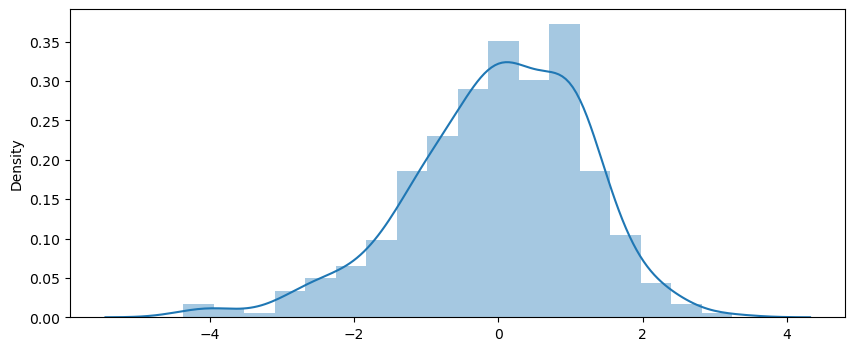

In [84]:
import seaborn as sns
sns.distplot(residuos_ma);

No histograma observamos uma assimetria e alguns picos que podems estar atrapalhando a normalidade dos resíduos

**Autocorrelação**

Verificando a autocorrelação dos resíduos

In [85]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

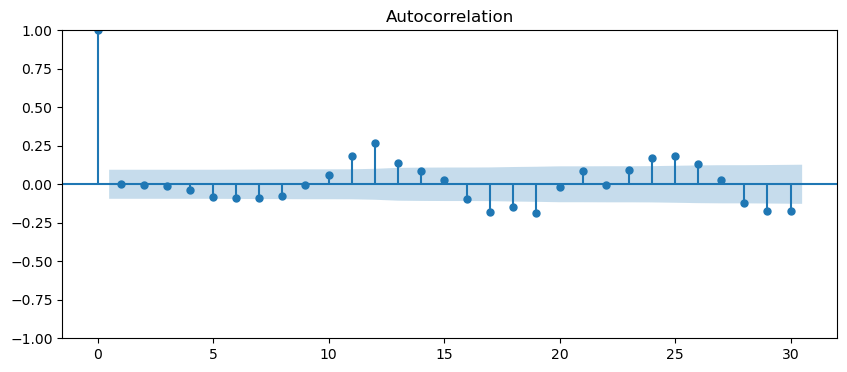

In [86]:
plot_acf(residuos_ma, lags=30)
plt.show()

Podemos verificar que existem muitos pontos fora do intervalo de confiança, apontando que existe uma autocorrelação.

C:\Users\anail\anaconda3\Lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


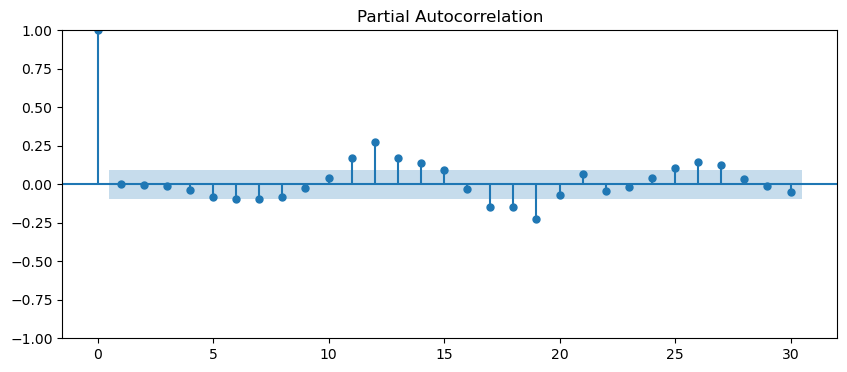

In [87]:
plot_pacf(residuos_ma, lags=30)
plt.show()

O mesmo observamos na autocorrelação parcial, onde temos muitos pontos fora do intervalo de confiança, apontando que axite uma autocorrelação.

Para o modelo MA temos que os resíduos:

*   Variância não constante
*   Não são normais
*   Estão autocorrelacionados

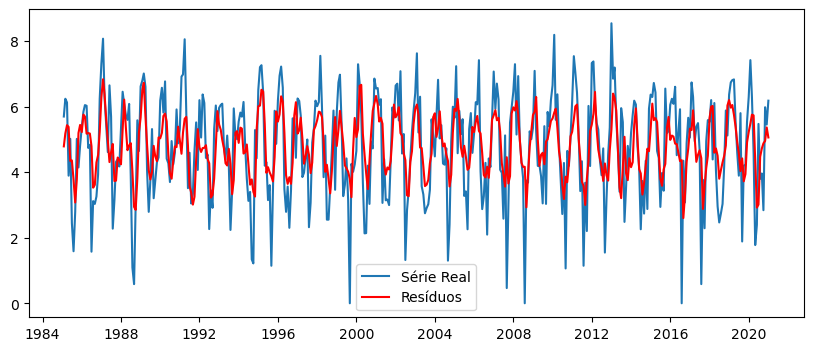

In [88]:
plt.plot(serie3, label='Série Real')
plt.plot(serie3-residuos_ma,color='red', label='Resíduos')
plt.legend(loc='best')
plt.show()

Observa-se uma coincidencia da foram em que os resíduos está oscilando versus o real.

**Previsão**

In [89]:
resultado_ma.fittedvalues

1985-01-31    4.786255
1985-02-28    5.179211
1985-03-31    5.432528
1985-04-30    5.379936
1985-05-31    4.341617
                ...   
2020-08-31    4.721012
2020-09-30    4.879099
2020-10-31    4.950800
2020-11-30    5.364027
2020-12-31    5.058304
Freq: M, Length: 432, dtype: float64

Mostra todos os valores ajustados pelo modelo

Previsão para 12 meses,  lembrando que o python inicia em 0, por isso temos que diminuir 1 em relaçã ao tamanho da série.

In [92]:
previsao_ma = resultado_ma.predict(start=431, end=443)
previsao_ma

2020-12-31    5.058304
2021-01-31    4.956918
2021-02-28    5.533746
2021-03-31    5.497440
2021-04-30    5.113150
2021-05-31    4.416556
2021-06-30    4.281338
2021-07-31    4.394365
2021-08-31    4.647503
2021-09-30    4.786255
2021-10-31    4.786255
2021-11-30    4.786255
2021-12-31    4.786255
Freq: M, Name: predicted_mean, dtype: float64

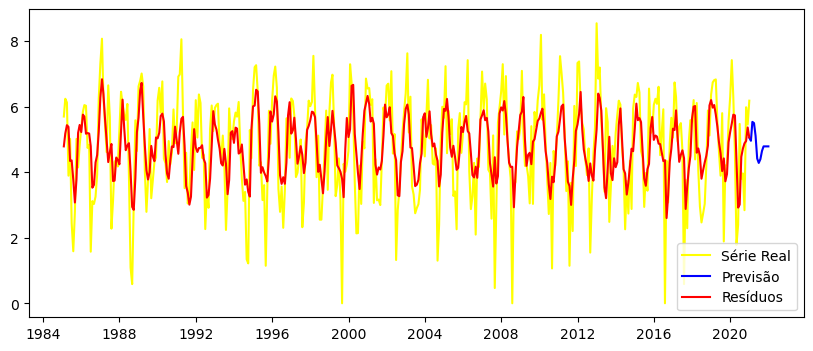

In [93]:
plt.plot(serie3,color='yellow', label='Série Real')
plt.plot(previsao_ma,color='blue', label='Previsão')
plt.plot(serie3-residuos_ma,color='red', label='Resíduos')
plt.legend(loc='best')
plt.show()

Aparentemente a predição não fica boa, pouca amplitude dos dados. E conforme analisado nos resíduos não temos um modelo adequado para predizer os dados utilizando o Modelo de média Móvel (MA).

Retornando a Escala original da série.

Neste caso como retiramos a raiz vubica devemos elevar ao cubo a nossa série.

In [94]:
prev_escala_ma = pd.DataFrame(previsao_ma**3)
prev_escala_ma

,predicted_mean
2020-12-31,129.424020
2021-01-31,121.796577
2021-02-28,169.456270
2021-03-31,166.142804
2021-04-30,133.679738
2021-05-31,86.149196
2021-06-30,78.476327
2021-07-31,84.857141
2021-08-31,100.382754
2021-09-30,109.644636


Concatenando a série original com a previsão encontrada.

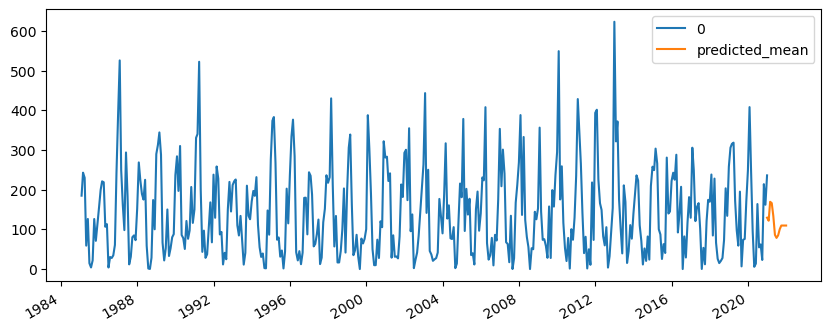

In [95]:
pd.concat([serie,prev_escala_ma]).plot();

## **Modelo ARMA**

Modelo Autoregressivo + Média Móvel

No modelo ARMA não incluímos nenhum parâmetro apenas para a diferenciação.

Modelo arima:(p,d,q)

*   p: ordem da autoregressão
*   d: grau de diferenciação (para transformar em estacionario)
*   q: Ordem de média móvel dos reísduos

Modelo arma: (p,0,q)

Modelo AR: AIC = 1337.922 (9,0,0)

Modelo MA: AIC = 1411.696 (0,0,8)

Nem sempre a combinação dos resultados encontrados anterioemnte será linear apra acharmos o modelo que minimiza o AIC no ARMA. Temos que verificar tambem se  tempo computacional não ficará muito elevado.

In [96]:
from statsmodels.tsa.arima.model import ARIMA

In [111]:
modelo_arma = ARIMA(serie3, order = (10,0,3))

In [112]:
resultado_arma = modelo_arma.fit()
print(resultado_arma.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  432
Model:                ARIMA(10, 0, 3)   Log Likelihood                -629.825
Date:                Mon, 27 Nov 2023   AIC                           1289.649
Time:                        22:05:50   BIC                           1350.676
Sample:                    01-31-1985   HQIC                          1313.742
                         - 12-31-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.7828      0.049     97.803      0.000       4.687       4.879
ar.L1          0.7427      0.057     12.976      0.000       0.630       0.855
ar.L2          0.6880      0.071      9.679      0.0

C:\Users\anail\anaconda3\Lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Observe que ele considerou o Modelo ARMA, ja desconsiderou o I de ARIMA. Uma vez que não incluimos e não se fez necessário valores para diferenciação.

Utilizando a combinação ARMA(9,0,8) teremos problemas de inversibilidade, problema da algébra linear onde os coeficiente MA não são invertíveis.

PAra evistar esse problema ao combinar modelo AR e MA devemos utilizar valores mais baixos para a ordem da média movel.


Modelo AR: AIC = 1337.922 (9,0,0)

Modelo MA: AIC = 1411.696 (0,0,8)

Modelo ARMA: Melhor AIC = 1273.766 (10,0,2)

### **Análise dos Resíduos**

Analisando os resíduos do modelo criado

In [113]:
residuos_arma = resultado_arma.resid

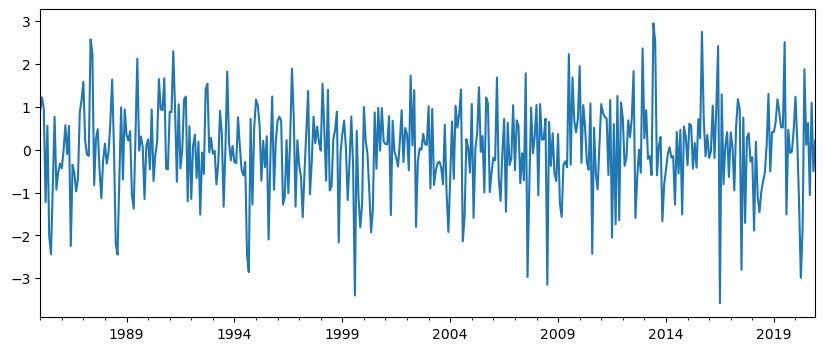

In [114]:
residuos_arma.plot()
plt.show()

A aprentemente a média é constante em torno de zero, porem existe alguns picos.

**Normalidade**

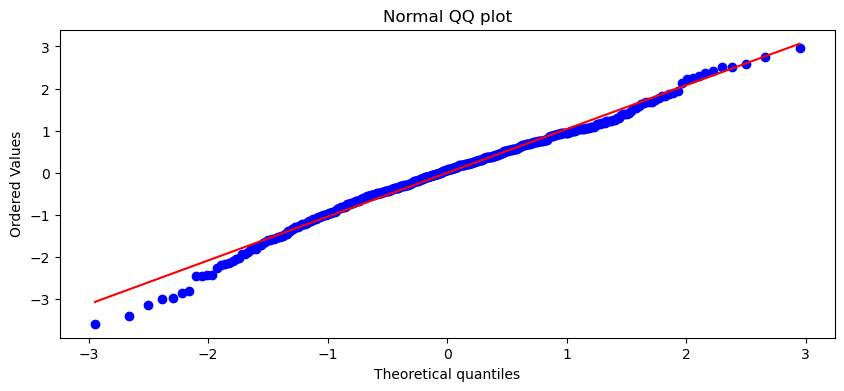

In [115]:
stats.probplot(residuos_arma, dist="norm", plot=plt)
plt.title("Normal QQ plot")
plt.show()

A normalidade dos residuos comparada a graficos e modelos anteriores graficamete aprece mais proxim da linah de referência.

Testando a normalidade pelo teste estatístico de Shapiro-Wilk

**Teste Shapiro-Wilk**

CRITÉRIOS:

NÍVEL DE SIGNIFICÂNCIA DE 0,05 ou 5% (MAIS UTILIZADO)

Ho = distribuição normal p > 0,05

Ha = distribuição não normal p <= 0,05

In [116]:
e, p = stats.shapiro(residuos_arma)
print('Estatística de teste: {}'.format(e))
print('p-valor: {}'.format(p))

Estatística de teste: 0.9878082275390625
p-valor: 0.0011209428776055574


Ainda não temos uma distribuição normal.

C:\Users\anail\AppData\Local\Temp\ipykernel_13324\146688118.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(residuos_arma);


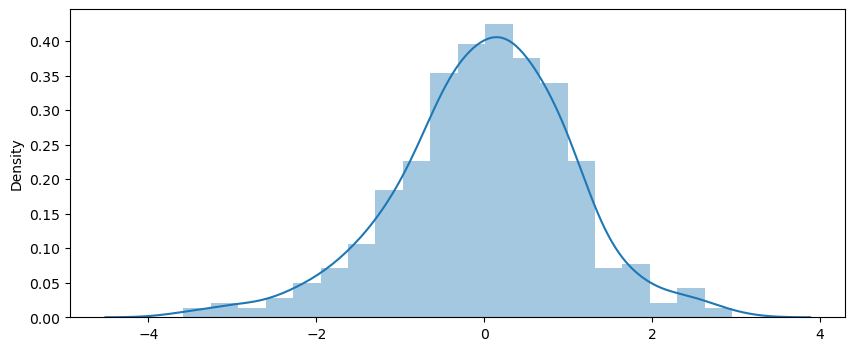

In [117]:
import seaborn as sns
sns.distplot(residuos_arma);

O histograma mostra uma leve assimetria dos dados. Porem visualmente essa distribuição está muito proxima da normalidade. Não tendo modelos melhores, poderíamos aceitar o ARMA.

**Autocorrelação**

Verificando se existe autocorrelação entre os resíduos.

In [118]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

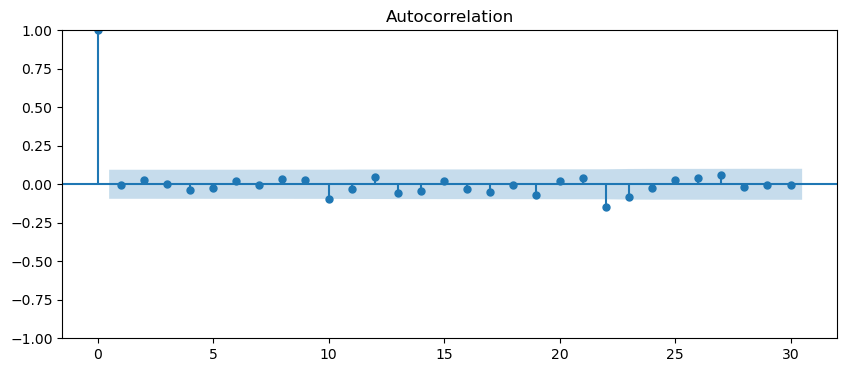

In [119]:
plot_acf(residuos_arma, lags=30)
plt.show()

Os resíduos não são autocorrelacionados, por apresentarem a amioria dos lags dentro do intervalo de confiança

C:\Users\anail\anaconda3\Lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


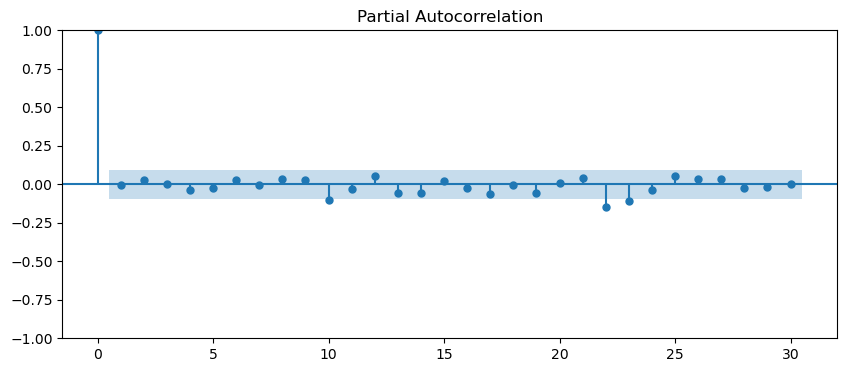

In [120]:
plot_pacf(residuos_arma, lags=30)
plt.show()

Verificando pelo grafico de correlação aprcial temos que os resíduos não são autocorrelacionados, por apresentarem a amioria dos lags dentro do intervalo de confiança

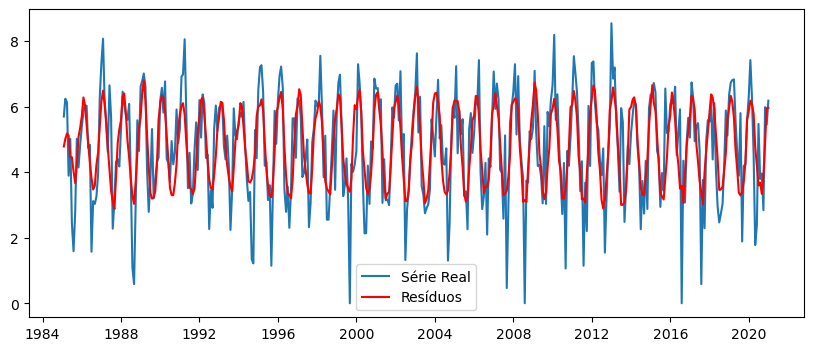

In [121]:
plt.plot(serie3, label='Série Real')
plt.plot(serie3-residuos_arma,color='red', label='Resíduos')
plt.legend(loc='best')
plt.show()

Observe que nesse modelo a amplitude se ajustou melhor, e está bem proximo a série original.
Bem uniforme e proxima a série original.

**Previsão**

In [122]:
resultado_arma.fittedvalues

1985-01-31    4.782817
1985-02-28    5.016971
1985-03-31    5.178381
1985-04-30    5.115344
1985-05-31    4.457705
                ...   
2020-08-31    3.336403
2020-09-30    3.897308
2020-10-31    4.884289
2020-11-30    5.951086
2020-12-31    5.963972
Freq: M, Length: 432, dtype: float64

Valores ajustados encontrado pelo modelo.

Realizando a previsão para 12 meses.

In [123]:
previsao_arma = resultado_arma.predict(start=431, end=455)
previsao_arma

2020-12-31    5.963972
2021-01-31    5.929935
2021-02-28    5.802624
2021-03-31    5.552665
2021-04-30    4.704291
2021-05-31    4.094229
2021-06-30    3.521299
2021-07-31    3.543551
2021-08-31    3.632498
2021-09-30    4.244573
2021-10-31    4.751575
2021-11-30    5.541835
2021-12-31    5.862919
2022-01-31    6.145826
2022-02-28    5.799221
2022-03-31    5.448736
2022-04-30    4.663263
2022-05-31    4.173396
2022-06-30    3.585429
2022-07-31    3.582697
2022-08-31    3.640241
2022-09-30    4.264622
2022-10-31    4.762088
2022-11-30    5.524012
2022-12-31    5.822637
Freq: M, Name: predicted_mean, dtype: float64

Plotando o gráfico para previsão

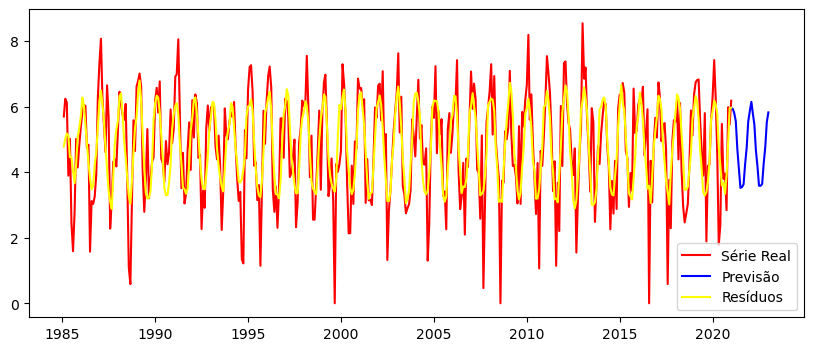

In [124]:
plt.plot(serie3,color='red', label='Série Real')
plt.plot(previsao_arma,color='blue', label='Previsão')
plt.plot(serie3-residuos_arma,color='yellow', label='Resíduos')
plt.legend(loc='best')
plt.show()

Revertendo a escala para voltar a original

In [125]:
prev_escala_arma = pd.DataFrame(previsao_arma ** 3)
prev_escala_arma

,predicted_mean
2020-12-31,212.132336
2021-01-31,208.521051
2021-02-28,195.376930
2021-03-31,171.200255
2021-04-30,104.107648
2021-05-31,68.630380
2021-06-30,43.662505
2021-07-31,44.495508
2021-08-31,47.930964
2021-09-30,76.471935


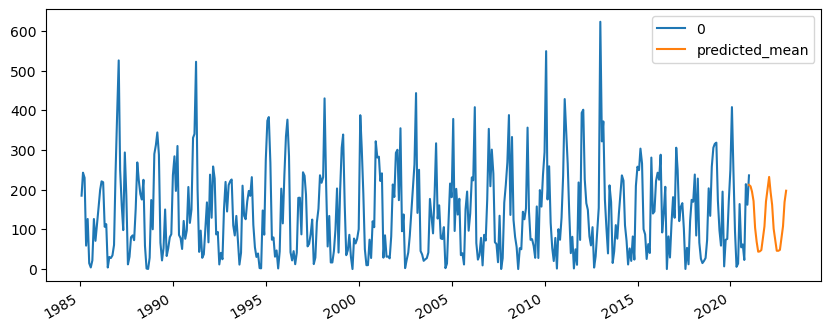

In [126]:
pd.concat([serie,prev_escala_arma]).plot();

## **Modelo ARIMA**

Modelo ARIMA:(p,d,q)

Neste modelo utilizamos os três parâmetros

*   p: ordem da autoregressão
*   d: grau de diferenciação (para transformar em estacionario)
*   q: Ordem de média móvel dos reísduos


Modelo AR: AIC = 1337.922 (9,0,0)

Modelo MA: Melhor AIC = 1411.696 (0,0,8)

Modelo ARMA: Melhor AIC = 1273.766 (10,0,2)

Para termos um modelo de ARIMA iremos colocar um valor para diferenciação mas na prática, não foi necessário realizar diferenciação, pois a serie ja era estacionária.

In [127]:
from statsmodels.tsa.arima.model import ARIMA

Vamos manter a configuração do ARMA e adicionar a diferenciação

Criando o modelo do ARIMA

In [128]:
modelo_arima = ARIMA(serie3, order = (10,1,2))

Verificando a saída do resumo do modelo

In [129]:
resultado_arima = modelo_arima.fit()
print(resultado_arima.summary())

C:\Users\anail\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  432
Model:                ARIMA(10, 1, 2)   Log Likelihood                -650.564
Date:                Mon, 27 Nov 2023   AIC                           1327.127
Time:                        22:13:29   BIC                           1379.987
Sample:                    01-31-1985   HQIC                          1347.998
                         - 12-31-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6983      0.070     10.029      0.000       0.562       0.835
ar.L2         -0.2311      0.066     -3.520      0.000      -0.360      -0.102
ar.L3         -0.2904      0.073     -3.977      0.0

C:\Users\anail\anaconda3\Lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Modelo AR: Melhor AIC = 1339.919 (10,0,0)

Modelo MA: Melhor AIC = 1411.696 (0,0,8)

Modelo ARMA: Melhor AIC = 1273.766 (10,0,2)

Modelo ARIMA: Melhor AIC = 1319.230 (10,1,2)

### **Análise dos Resíduos**

Validar o modelo ARIMA - a partir da análise de resíduos

In [130]:
residuos_arima = resultado_arima.resid

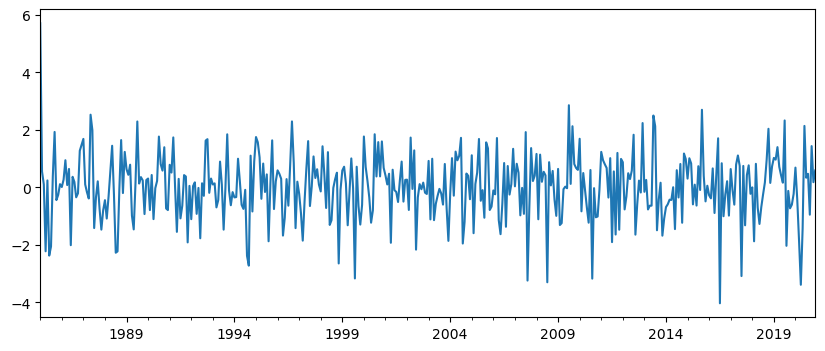

In [131]:
residuos_arima.plot()
plt.show()

Verificar se os residuos apresentam tendencia , se tem média contante em torno de zero e se a amplitude não está discrepante.

O ideal é que o resíduo seja um reído branco com media zero e variancia constante.



**Normalidade**

Analisando a normalidade dos resíduos

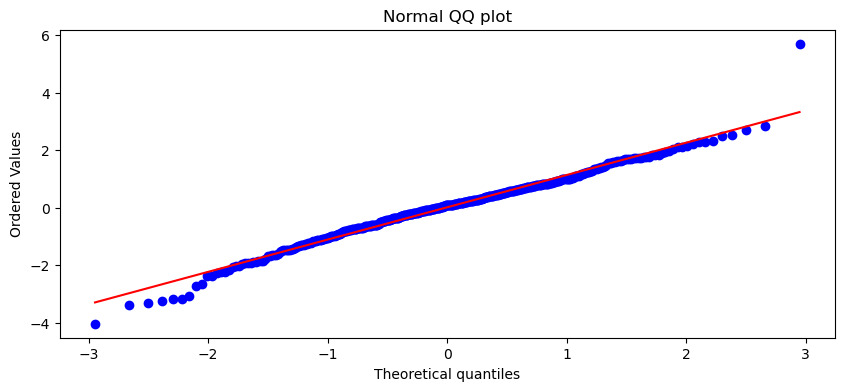

In [132]:
stats.probplot(residuos_arima, dist="norm", plot=plt)
plt.title("Normal QQ plot")
plt.show()

O Qq-plot, aparentemente não está ruim. no começo e no final da série apresentam dados um pouco dispersos.

**Teste Shapiro-Wilk**

CRITÉRIOS:

NÍVEL DE SIGNIFICÂNCIA DE 0,05 ou 5% (MAIS UTILIZADO)

Ho = distribuição normal p > 0,05

Ha = distribuição não normal p <= 0,05

A partir do teste numérico não temos normalidade nos resíduos.

In [133]:
e, p = stats.shapiro(residuos_arima)
print('Estatística de teste: {}'.format(e))
print('p-valor: {}'.format(p))

Estatística de teste: 0.981768786907196
p-valor: 2.9472790629370138e-05


C:\Users\anail\AppData\Local\Temp\ipykernel_13324\1993979180.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(residuos_arima);


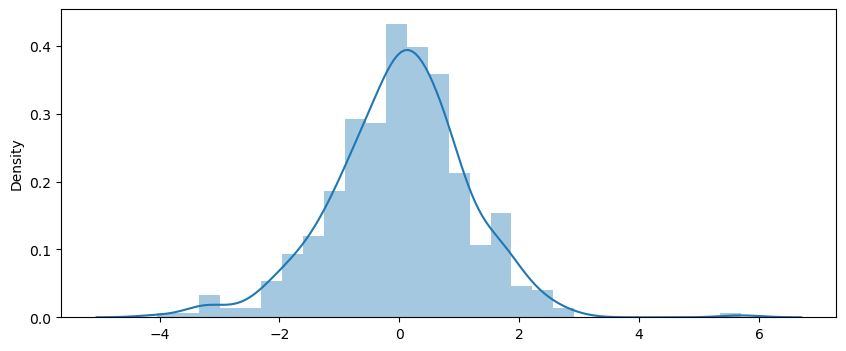

In [134]:
import seaborn as sns
sns.distplot(residuos_arima);

Na análise do histograma, para verificar a disposição da série observamos que sua distribuição aproxima de uma normal, visualmente

**Autocorrelação**

Verificando a autocorrelação residual.

In [135]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

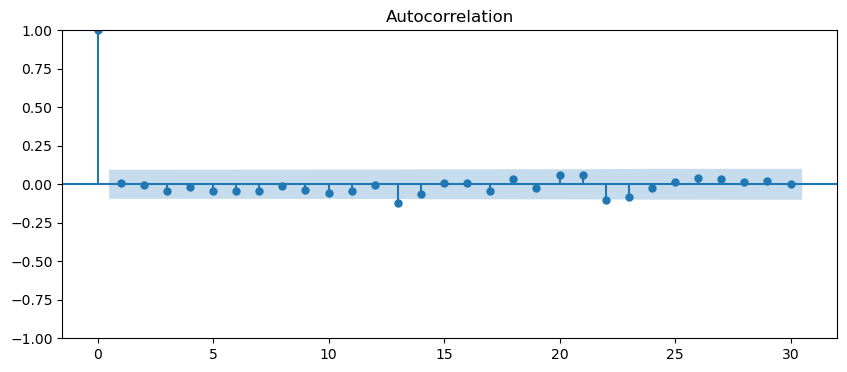

In [136]:
plot_acf(residuos_arima, lags=30)
plt.show()

A maioria dos lags estão dentro do intervalo de confiança, logo podemos dizer que pelo gráfico de autocorrelação os resíduals não são autocorrelacionados.

C:\Users\anail\anaconda3\Lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


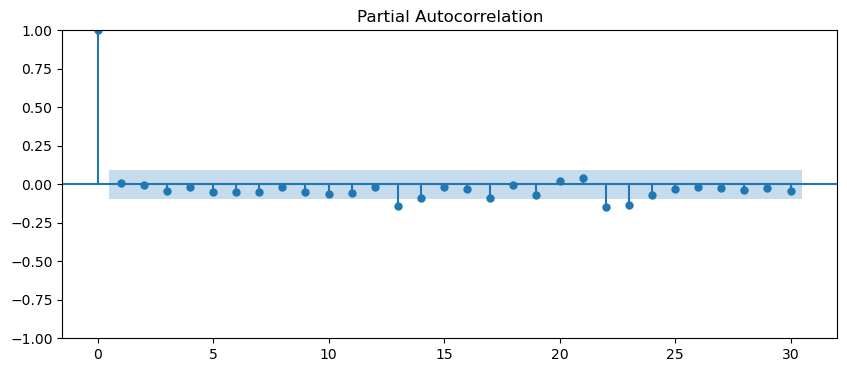

In [137]:
plot_pacf(residuos_arima, lags=30)
plt.show()

A partir da analise da autocorrelação parcial temos que a maioria dos lags estão dentro do intervalo de confiança, logo podemos que os resíduals não são autocorrelacionados.

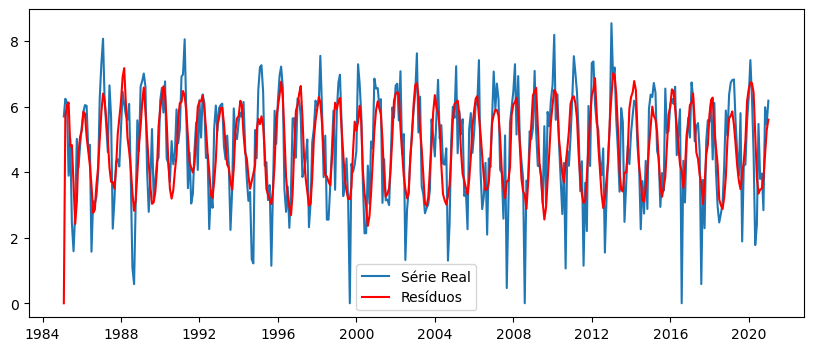

In [138]:
plt.plot(serie3, label='Série Real')
plt.plot(serie3-residuos_arima,color='red', label='Resíduos')
plt.legend(loc='best')
plt.show()

Plotando o grafico de resíduos e da série observamos que os resíduos estão adequados, dentro do que esperávamos. Ele consegue seguir as oscilações da série.

Observe que fazer a diferenciação ou não neste caso não irá alterar muito o modelo, pois ja temos uma série estacionária.

**Previsão**

Verificando os valores ajustados.

A série apresenta valores negativos pois realizamos a trasnformação e a diferenciação.

In [139]:
resultado_arima.fittedvalues

1985-01-31    0.000000
1985-02-28    5.696987
1985-03-31    6.035117
1985-04-30    6.126083
1985-05-31    4.785452
                ...   
2020-08-31    3.499048
2020-09-30    3.799923
2020-10-31    4.555470
2020-11-30    5.282389
2020-12-31    5.601427
Freq: M, Length: 432, dtype: float64

In [140]:
previsao_arima = resultado_arima.predict(start=430, end=443)
previsao_arima

2020-11-30    5.282389
2020-12-31    5.601427
2021-01-31    5.578182
2021-02-28    5.989906
2021-03-31    5.508322
2021-04-30    4.530252
2021-05-31    3.634722
2021-06-30    3.382665
2021-07-31    3.550880
2021-08-31    3.763632
2021-09-30    4.288797
2021-10-31    4.965006
2021-11-30    5.679974
2021-12-31    6.019765
Freq: M, Name: predicted_mean, dtype: float64

Temos que fazer uma transformação de dados - utilizando o predict isso daria mais trabalho pois não realiza a inversão da diferenciação de maneira automática.

Fazendo a previsão utilizando o método forecast -> ja resolve o problema da diferenciação

In [141]:
previsao_arima2 = resultado_arima.forecast(12)
previsao_arima2

2021-01-31    5.578182
2021-02-28    5.989906
2021-03-31    5.508322
2021-04-30    4.530252
2021-05-31    3.634722
2021-06-30    3.382665
2021-07-31    3.550880
2021-08-31    3.763632
2021-09-30    4.288797
2021-10-31    4.965006
2021-11-30    5.679974
2021-12-31    6.019765
Freq: M, Name: predicted_mean, dtype: float64

Revertendo a raiz cúbica

In [142]:
prev_escala_arima = pd.DataFrame(previsao_arima2**3)
prev_escala_arima

,predicted_mean
2021-01-31,173.571372
2021-02-28,214.911661
2021-03-31,167.131374
2021-04-30,92.975216
2021-05-31,48.019069
2021-06-30,38.705876
2021-07-31,44.772160
2021-08-31,53.311577
2021-09-30,78.887162
2021-10-31,122.393807


Observe que não temos as datas com essa função.

Concatenando a série original com a previsão do arima

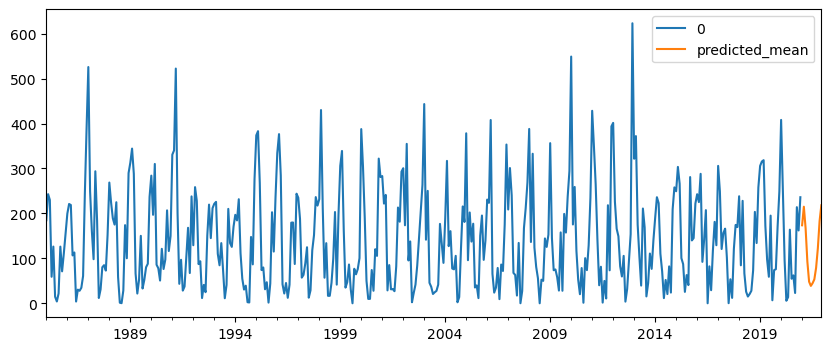

In [143]:
pd.concat([serie,prev_escala_arima]).plot();

Aparentemente obtemos uma boa previsão, com uma boa amplitude.

## **Modelo AUTO ARIMA**

Realiza todas as comparações de modelo e retorna o melhor modelo.

A função autoarima inclui a sazonalidade.

Na nossa série aparentemente temos uma sazonalidade bem definida.

Modelo arima:(p,d,q)

*   p: ordem da autoregressão
*   d: grau de diferenciação (para transformar em estacionario)
*   q: Ordem de média móvel dos reísduos


Modelo SARIMA: (p,d,q)(P,D,Q)

Modelo AR: Melhor AIC = 1337.922 = (9,0,0)

Modelo MA: Melhor AIC = 1411.696 (0,0,8)

Modelo ARMA: Melhor AIC = 1273.766 (10,0,2)

Modelo ARIMA: Melhor AIC = 1319.230 (10,1,2)

In [ ]:
#!pip install pmdarima

In [144]:
from pmdarima.arima import auto_arima

Criando modelo utilizando o autoarima.

Parâmetros:
*   Trace: Apresenta a lista de modelos testados
*   Stepwise: Seleção gradual do modelo "ideal", é um processo mais rápido porém menos minuncioso.
*   Seasonal: analisar a sazonalidade ou não
*   Parametros máximos a serem analidados SARIMA (p,d,q)(P,D,Q) -> interessante dobrar o default
*   M: período sazonal, no nosso caso é mensal.

In [145]:
modelo_auto = auto_arima(serie3, trace = True, stepwise = False, seasonal=True, max_p=10, max_q=10,
                          max_P=4, max_Q=4, start_p=0, start_q=0, start_P=0, start_Q=0, m=12,)

 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=1618.370, Time=0.02 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : AIC=1503.636, Time=0.09 sec
 ARIMA(0,0,0)(0,0,2)[12] intercept   : AIC=1474.263, Time=0.36 sec
 ARIMA(0,0,0)(0,0,3)[12] intercept   : AIC=1437.044, Time=0.64 sec
 ARIMA(0,0,0)(0,0,4)[12] intercept   : AIC=1419.293, Time=1.47 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : AIC=1427.651, Time=0.32 sec
 ARIMA(0,0,0)(1,0,1)[12] intercept   : AIC=inf, Time=0.79 sec
 ARIMA(0,0,0)(1,0,2)[12] intercept   : AIC=inf, Time=1.62 sec
 ARIMA(0,0,0)(1,0,3)[12] intercept   : AIC=1270.179, Time=2.80 sec
 ARIMA(0,0,0)(1,0,4)[12] intercept   : AIC=inf, Time=7.37 sec
 ARIMA(0,0,0)(2,0,0)[12] intercept   : AIC=1385.579, Time=0.84 sec
 ARIMA(0,0,0)(2,0,1)[12] intercept   : AIC=inf, Time=1.08 sec
 ARIMA(0,0,0)(2,0,2)[12] intercept   : AIC=1291.160, Time=1.66 sec
 ARIMA(0,0,0)(2,0,3)[12] intercept   : AIC=inf, Time=3.41 sec
 ARIMA(0,0,0)(3,0,0)[12] intercept   : AIC=inf, Time=2.36 sec
 ARIMA(0,0,0)(3,0,1)[12] 

C:\Users\anail\anaconda3\Lib\site-packages\pmdarima\arima\_auto_solvers.py:524: ModelFitWarning: Error fitting  ARIMA(0,0,0)(4,0,1)[12] intercept (if you do not want to see these warnings, run with error_action="ignore").
Traceback:
Traceback (most recent call last):
  File "C:\Users\anail\anaconda3\Lib\site-packages\pmdarima\arima\_auto_solvers.py", line 508, in _fit_candidate_model
    fit.fit(y, X=X, **fit_params)
  File "C:\Users\anail\anaconda3\Lib\site-packages\pmdarima\arima\arima.py", line 603, in fit
    self._fit(y, X, **fit_args)
  File "C:\Users\anail\anaconda3\Lib\site-packages\pmdarima\arima\arima.py", line 524, in _fit
    fit, self.arima_res_ = _fit_wrapper()
                           ^^^^^^^^^^^^^^
  File "C:\Users\anail\anaconda3\Lib\site-packages\pmdarima\arima\arima.py", line 510, in _fit_wrapper
    fitted = arima.fit(
             ^^^^^^^^^^
  File "C:\Users\anail\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\mlemodel.py", line 704, in fit
    mlefit = s

 ARIMA(0,0,0)(4,0,1)[12] intercept   : AIC=inf, Time=nan sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : AIC=1534.551, Time=0.07 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=1464.951, Time=0.16 sec
 ARIMA(0,0,1)(0,0,2)[12] intercept   : AIC=1448.732, Time=0.42 sec
 ARIMA(0,0,1)(0,0,3)[12] intercept   : AIC=1418.891, Time=0.74 sec
 ARIMA(0,0,1)(0,0,4)[12] intercept   : AIC=1406.458, Time=1.98 sec
 ARIMA(0,0,1)(1,0,0)[12] intercept   : AIC=1419.367, Time=0.40 sec
 ARIMA(0,0,1)(1,0,1)[12] intercept   : AIC=inf, Time=0.88 sec
 ARIMA(0,0,1)(1,0,2)[12] intercept   : AIC=inf, Time=1.76 sec
 ARIMA(0,0,1)(1,0,3)[12] intercept   : AIC=1279.359, Time=3.14 sec
 ARIMA(0,0,1)(2,0,0)[12] intercept   : AIC=1383.694, Time=0.74 sec
 ARIMA(0,0,1)(2,0,1)[12] intercept   : AIC=inf, Time=1.34 sec
 ARIMA(0,0,1)(2,0,2)[12] intercept   : AIC=inf, Time=1.84 sec
 ARIMA(0,0,1)(3,0,0)[12] intercept   : AIC=1340.191, Time=2.04 sec
 ARIMA(0,0,1)(3,0,1)[12] intercept   : AIC=inf, Time=4.02 sec
 ARIMA(0,0,1)(4,0,0)[12] i

C:\Users\anail\anaconda3\Lib\site-packages\pmdarima\arima\_auto_solvers.py:524: ModelFitWarning: Error fitting  ARIMA(2,0,0)(2,0,1)[12] intercept (if you do not want to see these warnings, run with error_action="ignore").
Traceback:
Traceback (most recent call last):
  File "C:\Users\anail\anaconda3\Lib\site-packages\pmdarima\arima\_auto_solvers.py", line 508, in _fit_candidate_model
    fit.fit(y, X=X, **fit_params)
  File "C:\Users\anail\anaconda3\Lib\site-packages\pmdarima\arima\arima.py", line 603, in fit
    self._fit(y, X, **fit_args)
  File "C:\Users\anail\anaconda3\Lib\site-packages\pmdarima\arima\arima.py", line 524, in _fit
    fit, self.arima_res_ = _fit_wrapper()
                           ^^^^^^^^^^^^^^
  File "C:\Users\anail\anaconda3\Lib\site-packages\pmdarima\arima\arima.py", line 510, in _fit_wrapper
    fitted = arima.fit(
             ^^^^^^^^^^
  File "C:\Users\anail\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\mlemodel.py", line 704, in fit
    mlefit = s

 ARIMA(2,0,0)(2,0,1)[12] intercept   : AIC=inf, Time=nan sec
 ARIMA(2,0,0)(3,0,0)[12] intercept   : AIC=inf, Time=2.90 sec
 ARIMA(2,0,1)(0,0,0)[12] intercept   : AIC=1498.246, Time=0.46 sec
 ARIMA(2,0,1)(0,0,1)[12] intercept   : AIC=inf, Time=0.91 sec
 ARIMA(2,0,1)(0,0,2)[12] intercept   : AIC=1441.657, Time=1.04 sec
 ARIMA(2,0,1)(1,0,0)[12] intercept   : AIC=1418.996, Time=0.74 sec
 ARIMA(2,0,1)(1,0,1)[12] intercept   : AIC=inf, Time=1.15 sec
 ARIMA(2,0,1)(2,0,0)[12] intercept   : AIC=1384.476, Time=1.81 sec
 ARIMA(2,0,2)(0,0,0)[12] intercept   : AIC=inf, Time=0.81 sec
 ARIMA(2,0,2)(0,0,1)[12] intercept   : AIC=inf, Time=1.23 sec
 ARIMA(2,0,2)(1,0,0)[12] intercept   : AIC=1411.064, Time=1.15 sec
 ARIMA(2,0,3)(0,0,0)[12] intercept   : AIC=1355.750, Time=0.76 sec
 ARIMA(3,0,0)(0,0,0)[12] intercept   : AIC=1471.799, Time=0.15 sec
 ARIMA(3,0,0)(0,0,1)[12] intercept   : AIC=1432.394, Time=0.39 sec
 ARIMA(3,0,0)(0,0,2)[12] intercept   : AIC=1423.727, Time=0.78 sec
 ARIMA(3,0,0)(1,0,0)[12] i

Encontramos o modelo com melhor AIC facilmente utilizando:

In [146]:
print(modelo_auto.aic())

1270.1786427528623


Modelo AR: Melhor AIC = 1339.919 (10,0,0)

Modelo MA: Melhor AIC = 1411.696 (0,0,8)

Modelo ARMA: Melhor AIC = 1273.766 (10,0,2)

Modelo ARIMA: Melhor AIC = 1319.230 (10,1,2)

Modelo_AUTOARIMA: AIC=1270.5894 ARIMA(0,0,0)(1,0,3)

Fazendo o ajuste utilizando o modelo autoarima

In [147]:
resultado_auto = modelo_auto.fit(serie3)
print(resultado_auto.summary())

                                    SARIMAX Results                                     
Dep. Variable:                                y   No. Observations:                  432
Model:             SARIMAX(1, 0, [1, 2, 3], 12)   Log Likelihood                -629.089
Date:                          Mon, 27 Nov 2023   AIC                           1270.179
Time:                                  22:20:47   BIC                           1294.589
Sample:                              01-31-1985   HQIC                          1279.816
                                   - 12-31-2020                                         
Covariance Type:                            opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0253      0.018      1.411      0.158      -0.010       0.060
ar.S.L12       0.9946      0.004    257.433      0.

O reusltado do autoarima é o melhor modelo pelo AIC.

### **Análise dos Resíduos**

Realizando a análise de residuos do modelo gerado pelo autoarima.

Observe que a função de analise de residuos é diferente pois estamos utilizando outra biblioteca.

In [148]:
residuos_auto = resultado_auto.resid
residuos_auto()

1985-01-31    0.981689
1985-02-28    1.524092
1985-03-31    1.411622
1985-04-30   -0.822307
1985-05-31    0.300646
                ...   
2020-08-31    1.085512
2020-09-30   -1.134656
2020-10-31    1.195445
2020-11-30    0.156437
2020-12-31    0.143806
Freq: M, Length: 432, dtype: float64

Plotando os residuos

Aparentemente temos uma média constante (não há tendencia)
Variância não se amntém contante, amplitude varia




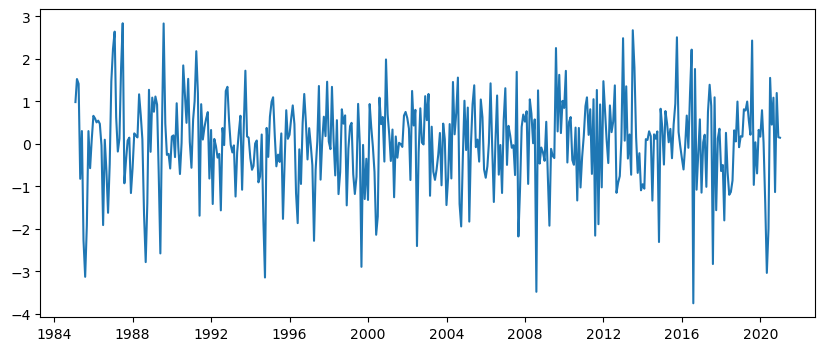

In [149]:
plt.plot(residuos_auto())
plt.show()

**Normalidade**

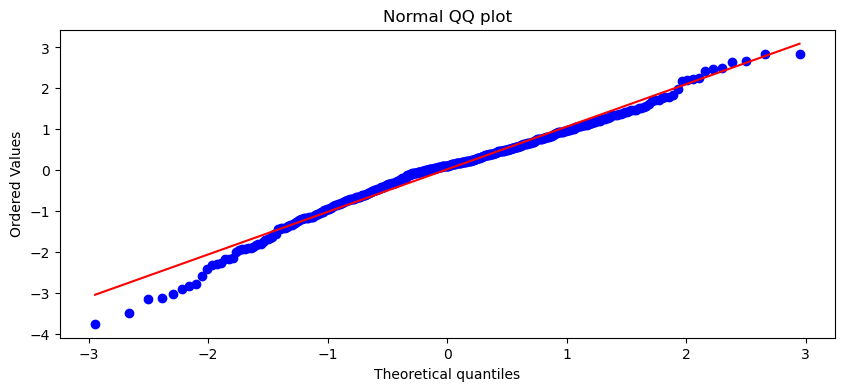

In [150]:
stats.probplot(residuos_auto(), dist="norm", plot=plt)
plt.title("Normal QQ plot")
plt.show()

Realizando o teste de normalidade para os residuos, observamos que os dados iniciais e finais se afastam um pouco da linah de referência.


**Teste Shapiro-Wilk**

CRITÉRIOS:

NÍVEL DE SIGNIFICÂNCIA DE 0,05 ou 5% (MAIS UTILIZADO)

Ho = distribuição normal p > 0,05

Ha = distribuição não normal p <= 0,05

In [151]:
e, p = stats.shapiro(residuos_auto())
print('Estatística de teste: {}'.format(e))
print('p-valor: {}'.format(p))

Estatística de teste: 0.9811800718307495
p-valor: 2.1301468223100528e-05


O p-valor é < que 0,05 indicando que a distribuição não é normal

C:\Users\anail\AppData\Local\Temp\ipykernel_13324\1563776940.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(residuos_auto());


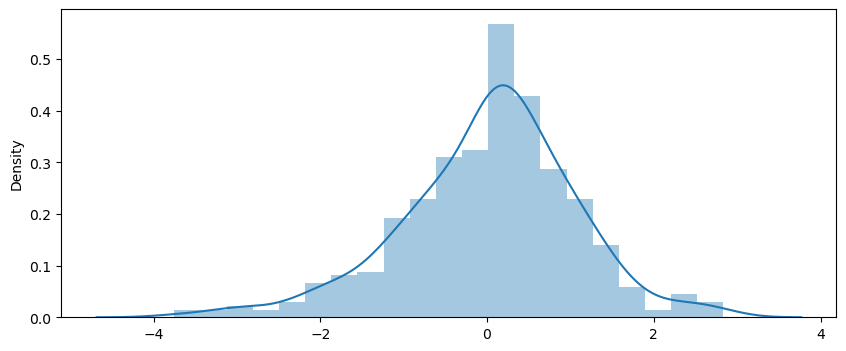

In [152]:
import seaborn as sns
sns.distplot(residuos_auto());

Temos um pico na distribuição, porem os dados se aproximam de uma normalidade

**Autocorrelação**

In [153]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

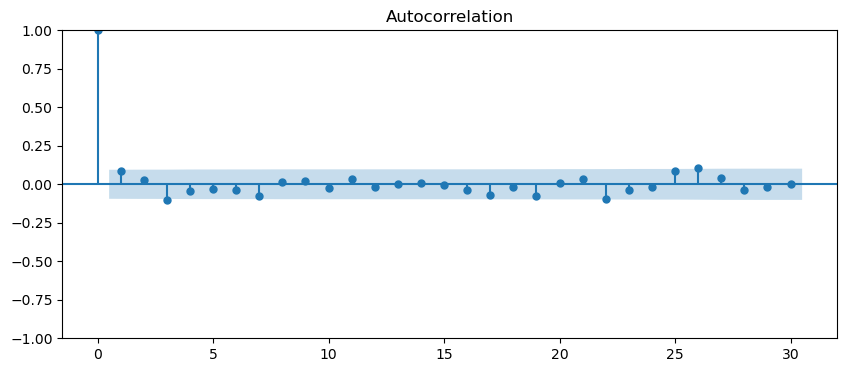

In [154]:
plot_acf(residuos_auto(), lags=30)
plt.show()

Existem lags que saem  do intervalo de confiaça, porem a maioria fica dentro do intervalo. logo não há autocorrelação nos resíduos

C:\Users\anail\anaconda3\Lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


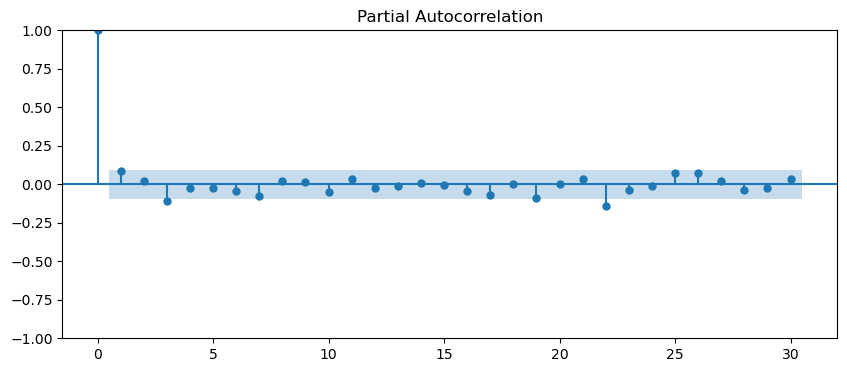

In [155]:
plot_pacf(residuos_auto(), lags=30)
plt.show()

Para analise de correlação parcial temos o mesmo, existem lags que saem  do intervalo de confiaça, porem a maioria fica dentro do intervalo. logo não há autocorrelação nos resíduos

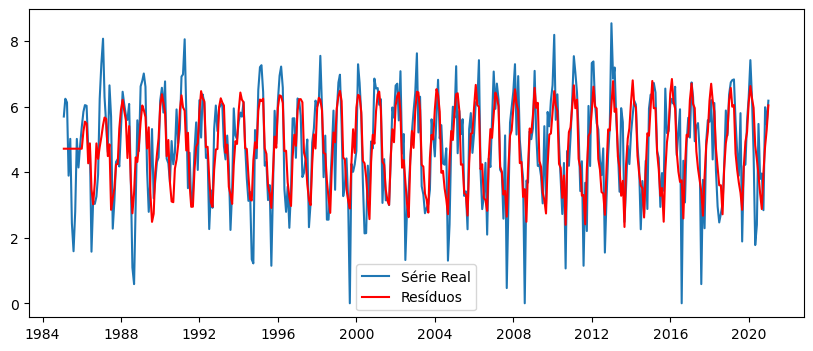

In [156]:
plt.plot(serie3, label='Série Real')
plt.plot(serie3-residuos_auto(),color='red', label='Resíduos')
plt.legend(loc='best')
plt.show()

plotando a sére com os resíduos, observamo que em geral seguem bem os dados , porem no início temos uma pequena diferença.

**Previsão**

Fazendo a previsão de 12 meses.

In [157]:
previsao_auto = resultado_auto.predict(n_periods=12)
previsao_auto

2021-01-31    6.610100
2021-02-28    5.964919
2021-03-31    5.786885
2021-04-30    4.371844
2021-05-31    4.022828
2021-06-30    3.904471
2021-07-31    3.045755
2021-08-31    3.111280
2021-09-30    3.883285
2021-10-31    5.073875
2021-11-30    5.264676
2021-12-31    6.046049
Freq: M, dtype: float64

Transformando os dados , retornando a escala inicial -> elevar ao cubo

In [158]:
prev_escala_auto = pd.DataFrame(previsao_auto ** 3, columns=['Previsão_SARIMA'])
prev_escala_auto

,Previsão_SARIMA
2021-01-31,288.817855
2021-02-28,212.233371
2021-03-31,193.791441
2021-04-30,83.559156
2021-05-31,65.101998
2021-06-30,59.523235
2021-07-31,28.254310
2021-08-31,30.117382
2021-09-30,58.559540
2021-10-31,130.622872


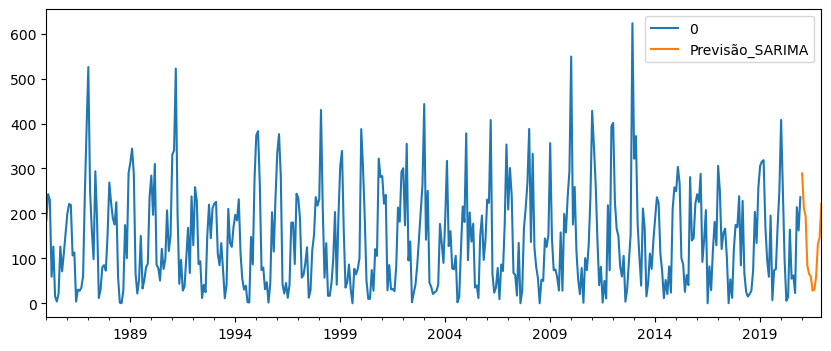

In [159]:
pd.concat([serie,prev_escala_auto]).plot();

A previsão consegue seguir o padrão da série.

## **Análise final do projeto**

Para comparar o modelo utilizamos a métrica AIC

**COMPARAÇÃO DOS MODELOS**

Modelo AR: Melhor AIC = 1339.919 (10,0,0)

Modelo MA: Melhor AIC = 1411.696 (0,0,8)

Modelo ARMA: Melhor AIC = 1273.766 (10,0,2)

Modelo ARIMA: Melhor AIC = 1319.230 (10,1,2)

**Modelo_SARIMA (AutoArima): AIC=1270.5894 ARIMA(0,0,0)(1,0,3)**

**DESEMPENHO DOS MODELOS**

Para verificar o desempenho dos modelos vamso utilizar:


*   ERRO MÉDIO ABSOLUTO (MAE)
*   RAIZ DO ERRO QUADRÁTICO MÉDIO (RMSE)



Vamos realizar a comparação utilizando os meses de 2021, que foram separados inicialmente.

Criando uma lista apra os valores reais

In [ ]:
lista = [373.3, 174.1, 137.8, 55.7]
valores_reais = pd.DataFrame(lista, columns = ['valores reais'])
print(valores_reais)

Os 4 primeiros valores previstos de cada modelo, observe que alguns colocamos para iniciar em dezembro e outros em janeiro.

In [ ]:
auto = prev_escala_auto.iloc[0:4]
ar = prev_escala.iloc[1:5]
ma = prev_escala_ma.iloc[1:5]
arima = prev_escala_arima.iloc[0:4]
arma = prev_escala_arma.iloc[1:5]


In [ ]:
auto

In [ ]:
ar

Excluindo índice para os que estavam com datas

In [ ]:
pd.DataFrame.reset_index(ar, drop=True, inplace=True)
pd.DataFrame.reset_index(ma, drop=True, inplace=True)
pd.DataFrame.reset_index(arma, drop=True, inplace=True)
pd.DataFrame.reset_index(auto, drop=True, inplace=True)
pd.DataFrame.reset_index(arima, drop=True, inplace=True)

Criando um dataframe para concatenar os valores reais e a predição do autoarima

In [ ]:
desempenho = pd.concat([valores_reais, auto, ar, ma, arma, arima],axis=1)
desempenho

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

**ERRO MÉDIO ABSOLUTO (MAE)**

In [ ]:
print('ERRO MÉDIO ABSOLUTO (MAE)')
mae_sarima = mean_absolute_error(desempenho['valores reais'], desempenho.iloc[:, 1])
print('SARIMA: {:.2f}'.format(mae_sarima))
mae_ar = mean_absolute_error(desempenho['valores reais'], desempenho.iloc[:, 2])
print('AR: {:.2f}'.format(mae_ar))
mae_ma = mean_absolute_error(desempenho['valores reais'], desempenho.iloc[:, 3])
print('MA: {:.2f}'.format(mae_ma))
mae_arma = mean_absolute_error(desempenho['valores reais'], desempenho.iloc[:, 4])
print('ARMA: {:.2f}'.format(mae_arma))
mae_arima = mean_absolute_error(desempenho['valores reais'], desempenho.iloc[:, 5])
print('ARIMA: {:.2f}'.format(mae_arima))

**ERRO QUADRÁTICO MÉDIO (MSE)**

In [ ]:
print('ERRO QUADRÁTICO MÉDIO (MSE)')
mse_sarima = mean_squared_error(desempenho['valores reais'], desempenho.iloc[:, 1])
print('SARIMA: {:.2f}'.format(mse_sarima))
mse_ar = mean_squared_error(desempenho['valores reais'], desempenho.iloc[:, 2])
print('AR: {:.2f}'.format(mse_ar))
mse_ma = mean_squared_error(desempenho['valores reais'], desempenho.iloc[:, 3])
print('MA: {:.2f}'.format(mse_ma))
mse_arma = mean_squared_error(desempenho['valores reais'], desempenho.iloc[:, 4])
print('ARMA: {:.2f}'.format(mse_arma))
mse_arima = mean_squared_error(desempenho['valores reais'], desempenho.iloc[:, 5])
print('ARIMA: {:.2f}'.format(mse_arima))

**RAIZ DO ERRO QUADRÁTICO MÉDIO (RMSE)**

In [ ]:
print('RAIZ DO ERRO QUADRÁTICO MÉDIO (RMSE)')
rmse_sarima = mean_squared_error(desempenho['valores reais'], desempenho.iloc[:, 1], squared=False)
print('SARIMA: {:.2f}'.format(rmse_sarima))
rmse_ar = mean_squared_error(desempenho['valores reais'], desempenho.iloc[:, 2], squared=False)
print('AR: {:.2f}'.format(rmse_ar))
rmse_ma = mean_squared_error(desempenho['valores reais'], desempenho.iloc[:, 3], squared=False)
print('MA: {:.2f}'.format(rmse_ma))
rmse_arma = mean_squared_error(desempenho['valores reais'], desempenho.iloc[:, 4], squared=False)
print('ARMA: {:.2f}'.format(rmse_arma))
rmse_arima = mean_squared_error(desempenho['valores reais'], desempenho.iloc[:, 5], squared=False)
print('ARIMA: {:.2f}'.format(rmse_arima))